# Comparison between Leadmine and PubChem Name2SMILES translation

We want to compare how Leadmine and PubChem differ in the translation of names to SMILES. The analysis will help to decide which one to use for the translation of the names in the dataset and how we could correct potential errors.

In [3]:
import os
import subprocess
import tarfile

import pandas as pd
import pubchempy as pcp  # pip install pubchempy
import requests
from py2opsin import py2opsin  # pip install py2opsin
from rdkit import Chem
from rdkit.Chem import PandasTools

from choriso.data.processing.preproc import download_raw_data, get_structures_from_name

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# Functions for PubChem and py2opsin translation


def query_opsin_pubchem(name: str) -> str:
    """Query name of compound in OpSin and if it fails query PubChem"""

    query = py2opsin(name)

    if query == "":
        query = pcp.get_compounds(name, "name")
        if query == []:
            return "empty"
        else:
            return query[0].canonical_smiles
    else:
        return query


def get_smiles_opsin_pubchem(name, format_bond=True):
    """Get SMILES string from OpSin and if it fails query PubChem

    Args:
        name (str): name of compound
        format_bond (bool): if True, replace '.' with '~' in SMILES string

    Returns:
        str: SMILES string
    """

    names = name.split("|")

    # smiles = [translator(name) for name in names]
    structures = {str(query_opsin_pubchem(name)) for name in names}
    structures.discard("None")
    structures.discard("")

    if format_bond:
        structures = [structure.replace(".", "~") for structure in structures]

    structures = ".".join(structures)

    return structures

## Importing raw data from CJHIF

In [5]:
# If raw data not downloaded
if not os.path.isfile("data/raw/data_from_CJHIF_utf8"):
    print("Dataset not found, downloading CJHIF ...")
    os.makedirs("data/raw")
    download_raw_data()

# import dataset
cjhif_df = pd.read_csv("data/raw/data_from_CJHIF_utf8", sep="\t", header=None)
# Fill NaN with empty strings
cjhif_df.fillna("empty", inplace=True)
# Drop columns 1 and 2
cjhif_df.drop(labels=[1, 2], axis=1, inplace=True)
# Rename columns
cjhif_df.rename(
    columns={
        0: "rxn_smiles",
        3: "reagent",
        4: "solvent",
        5: "catalyst",
        6: "yield",
    },
    inplace=True,
)

Dataset not found, downloading CJHIF ...


## Sample of 300 data points

We take a random subset of reactions to manually analyse them

In [6]:
sample_df = cjhif_df.sample(n=300, random_state=33)

## Translate names using Leadmine, PubChem and py2opsin

In [ ]:
# This cell takes about 8 min to run (parallel_apply is not working for some reasons)

sample_df["reagent_SMILES_leadmine"] = sample_df["reagent"].apply(
    get_structures_from_name
)
sample_df["catalyst_SMILES_leadmine"] = sample_df["catalyst"].apply(
    get_structures_from_name
)

sample_df["reagent_SMILES_pubchem"] = sample_df["reagent"].apply(
    get_smiles_opsin_pubchem
)
sample_df["catalyst_SMILES_pubchem"] = sample_df["catalyst"].apply(
    get_smiles_opsin_pubchem
)

In [13]:
sample_df.to_csv("sample_cjhif_translated.csv", index=True)

## Data analysis

We create a function to plot the SMILES rdkit objects in each translated column and manually check the results.

In [14]:
# Defining function to compare the translation results


def compare(
    df_in: pd.DataFrame,
    *,
    name_col: str,
    smiles_leadmine_col: str,
    smiles_pubchem_col: str,
) -> pd.DataFrame:
    """
    Compare two translated SMILES strings and check if they are the same.

    Args:
        df_in (pd.DataFrame): Input DataFrame
        name_col (str): Coloumn name of the compound name
        smiles_leadmine_col (str): Coloumn name of the translated SMILES string from LeadMine
        smiles_pubchem_col (str): Coloumn name of the translated SMILES string from PubChem

    Returns:
        pd.DataFrame: DataFrame to compare the SMILES strings
    """
    df = df_in.copy()
    df.fillna("", inplace=True)
    df = df[[name_col, smiles_leadmine_col, smiles_pubchem_col]]

    def clean_smiles(smiles):
        return (
            smiles.replace("~", ".")
            .replace(".empty", "")
            .replace("empty.", "")
            .replace("empty", "")
        )

    df[smiles_leadmine_col] = df[smiles_leadmine_col].apply(clean_smiles)
    df[smiles_pubchem_col] = df[smiles_pubchem_col].apply(clean_smiles)

    results = []

    for i, row in df.iterrows():
        name = row[name_col]
        smiles_leadmine = row[smiles_leadmine_col]
        smiles_pubchem = row[smiles_pubchem_col]

        if (smiles_leadmine == "") or (smiles_pubchem == ""):
            results.append([name, "", "", False, None, None])
            continue

        mol_leadmine = Chem.MolFromSmiles(smiles_leadmine)
        mol_pubchem = Chem.MolFromSmiles(smiles_pubchem)

        can_mol_leadmine = Chem.MolToSmiles(mol_leadmine)
        can_mol_pubchem = Chem.MolToSmiles(mol_pubchem)
        correct = can_mol_leadmine == can_mol_pubchem

        results.append(
            [name, can_mol_leadmine, can_mol_pubchem, correct, None, None]
        )

    result_df = pd.DataFrame(
        results,
        columns=[
            name_col,
            "canonical_leadmine",
            "canonical_pubchem",
            "is_correct",
            "leadmine_image",
            "pubchem_image",
        ],
    )
    PandasTools.AddMoleculeColumnToFrame(
        result_df, smilesCol="canonical_leadmine", molCol="leadmine_image"
    )
    PandasTools.AddMoleculeColumnToFrame(
        result_df, smilesCol="canonical_pubchem", molCol="pubchem_image"
    )

    return result_df

In [81]:
# uncomment the one you want to analyse

# part_1_catalyst = compare(sample_df[:150], name_col="catalyst", smiles_leadmine_col="catalyst_SMILES_leadmine", smiles_pubchem_col="catalyst_SMILES_pubchem")
# part_2_catalyst = compare(sample_df[150:], name_col="catalyst", smiles_leadmine_col="catalyst_SMILES_leadmine", smiles_pubchem_col="catalyst_SMILES_pubchem")


part_1_reagent = compare(
    sample_df[:150],
    name_col="reagent",
    smiles_leadmine_col="reagent_SMILES_leadmine",
    smiles_pubchem_col="reagent_SMILES_pubchem",
)
part_2_reagent = compare(
    sample_df[150:],
    name_col="reagent",
    smiles_leadmine_col="reagent_SMILES_leadmine",
    smiles_pubchem_col="reagent_SMILES_pubchem",
)

[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom without neighbors
[16:55:20] WARNING: not removing hydrogen atom wit

In [80]:
# run some statistics
# first create a dataframe where the reagent column does not contain any empty strings
df = part_1_reagent[part_1_reagent["reagent"] != "empty"]

# then print in how many rows:
# canonical_leadmine and canonical_pubchem have the same string
# canonical_leadmine has an empty string and canonical_pubchem has a SMILES string
# canonical_leadmine has a SMILES string and canonical_pubchem has an empty string
# canonical_leadmine and canonical_pubchem have different SMILES strings

print(
    "canonical_leadmine and canonical_pubchem have the same string: ",
    len(
        df[
            (df["canonical_leadmine"] != "")
            & (df["canonical_pubchem"] != "")
            & (df["canonical_leadmine"] == df["canonical_pubchem"])
        ]
    ),
)
print(
    "canonical_leadmine and canonical_pubchem have the same string but it's empty: ",
    len(
        df[
            (df["canonical_leadmine"] == "")
            & (df["canonical_pubchem"] == "")
            & (df["canonical_leadmine"] == df["canonical_pubchem"])
        ]
    ),
)
print(
    "canonical_leadmine has an empty string and canonical_pubchem has a SMILES string: ",
    len(
        df[
            (df["canonical_leadmine"] == "empty")
            & (df["canonical_pubchem"] != "")
        ]
    ),
)
print(
    "canonical_leadmine has a SMILES string and canonical_pubchem has an empty string: ",
    len(
        df[
            (df["canonical_leadmine"] != "empty")
            & (df["canonical_pubchem"] == "")
        ]
    ),
)
print(
    "canonical_leadmine and canonical_pubchem have different SMILES strings: ",
    len(
        df[
            (df["canonical_leadmine"] != "")
            & (df["canonical_pubchem"] != "")
            & (df["canonical_leadmine"] != df["canonical_pubchem"])
        ]
    ),
)

canonical_leadmine and canonical_pubchem have the same string:  105
canonical_leadmine and canonical_pubchem have the same string but it's empty:  13
canonical_leadmine has an empty string and canonical_pubchem has a SMILES string:  0
canonical_leadmine has a SMILES string and canonical_pubchem has an empty string:  13
canonical_leadmine and canonical_pubchem have different SMILES strings:  23


Check first part

,reagent,canonical_leadmine,canonical_pubchem,is_correct,leadmine_image,pubchem_image
0,empty,,,False,,
1,triethylamine,CCN(CC)CC,CCN(CC)CC,True,,
2,copper(l) iodide|potassium carbonate|(2s)-(-)-...,CC(=O)O.O=C(O)[C@@H]1C[C@@H](O)CN1.O=C([O-])[O...,CC(=O)O.O=C(O)[C@@H]1C[C@@H](O)CN1.O=C([O-])[O...,False,,
3,water|trifluoroacetic acid,O.O=C(O)C(F)(F)F,O.O=C(O)C(F)(F)F,True,,
4,potassium fluoride|18-crown-6 ether,C1COCCOCCOCCOCCOCCO1.[F-].[K+],C1COCCOCCOCCOCCOCCO1.[F-].[K+],True,,
5,scandium tris(trifluoromethanesulfonate),O=S(=O)([O-])C(F)(F)F.O=S(=O)([O-])C(F)(F)F.O=...,O=S(=O)([O-])C(F)(F)F.O=S(=O)([O-])C(F)(F)F.O=...,True,,
6,sodium thiosulfate,O=S([O-])([O-])=S.[Na+].[Na+],O=S([O-])([O-])=S.[Na+].[Na+],True,,
7,"2,2,2-trifluroethylamine hydrochloride|n-ethyl...",Cl.NCC(F)(F)F,CCN(C(C)C)C(C)C,False,,
8,n-bromosuccinmide,,,False,,
9,n-iodo-succinimide|boron trifluoride diethyl e...,CC[O+](CC)[B-](F)(F)F,CCOCC.FB(F)F.O=C1CCC(=O)N1I,False,,

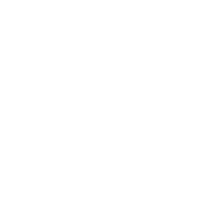
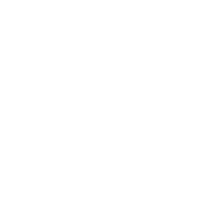
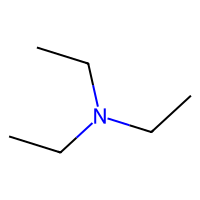
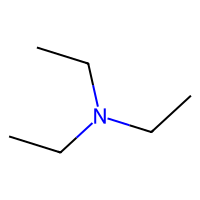
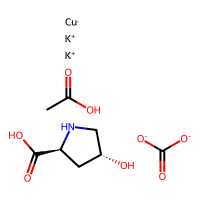
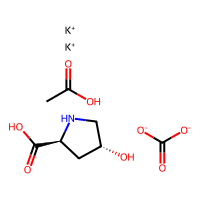
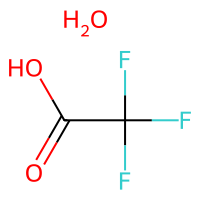
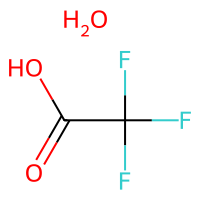
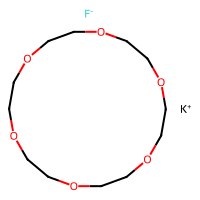
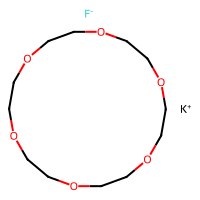
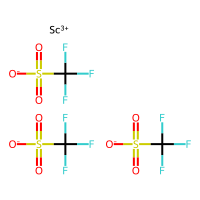
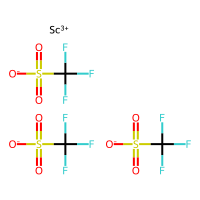
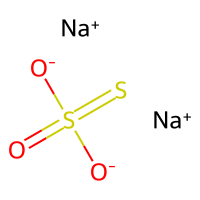
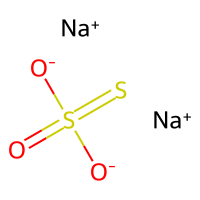
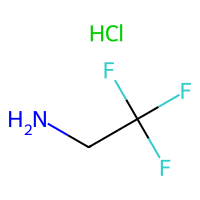
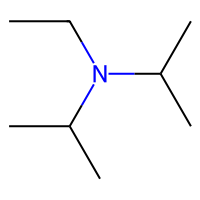
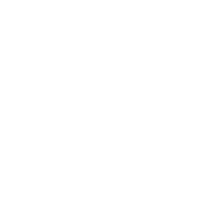
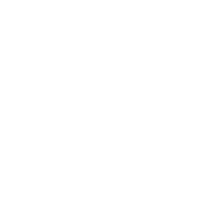
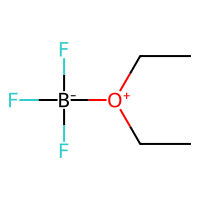
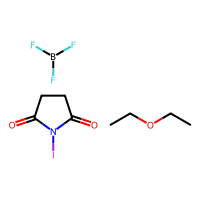
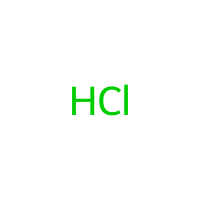
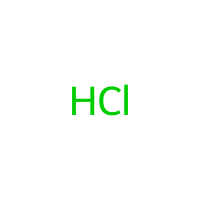
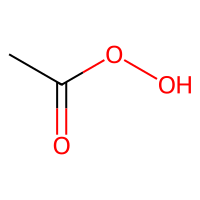
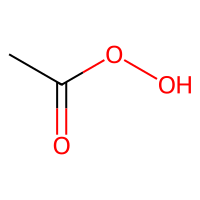
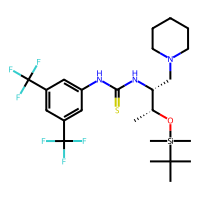
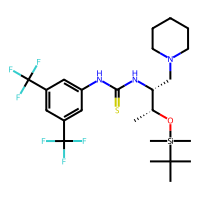
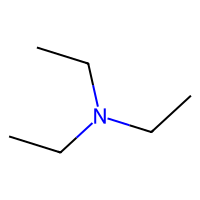
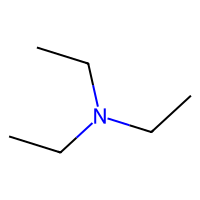
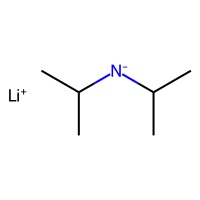
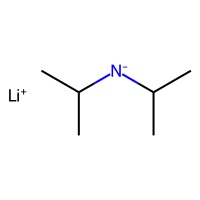
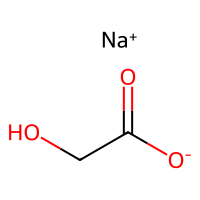
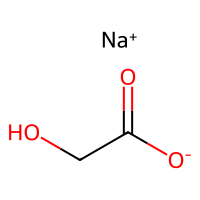
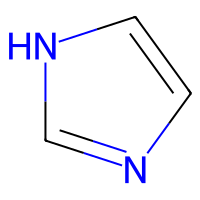
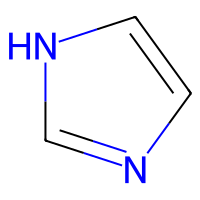
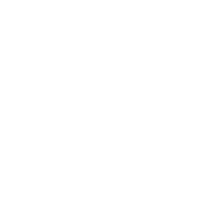
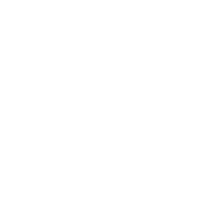
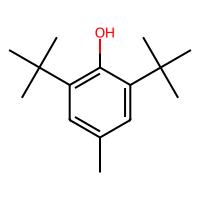
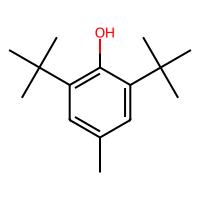
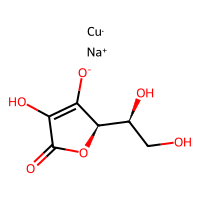
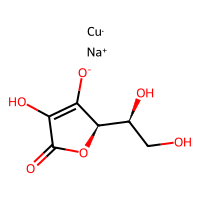
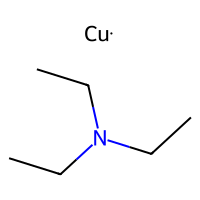
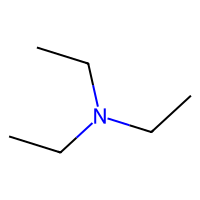
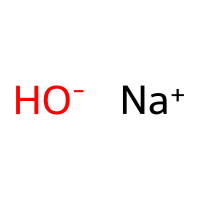
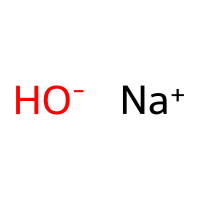
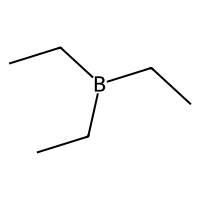
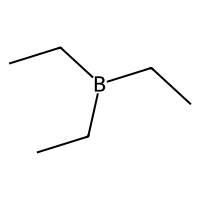
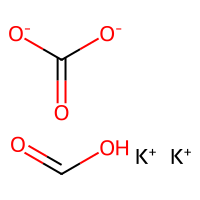
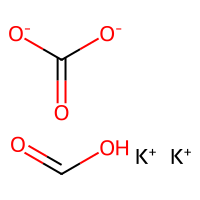
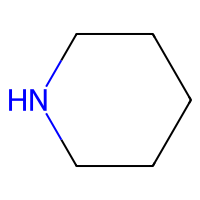
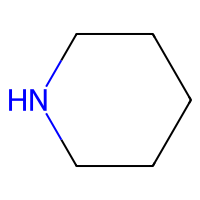
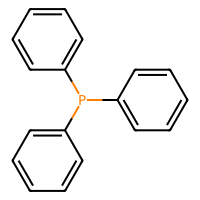
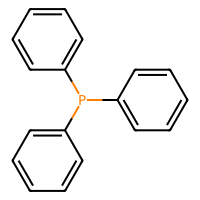
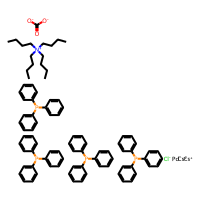
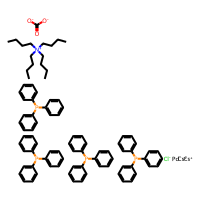
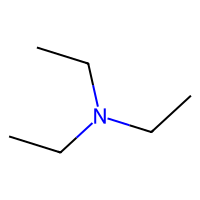
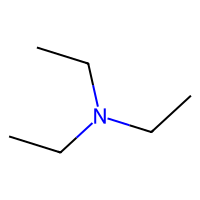
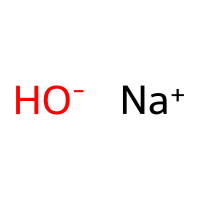
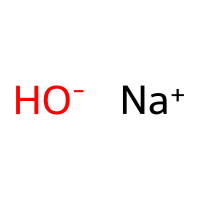
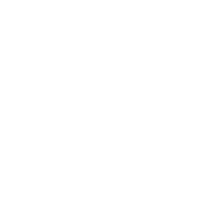
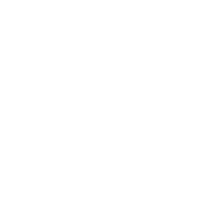
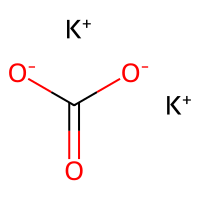
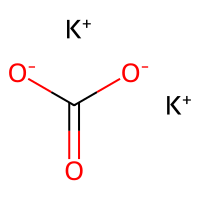
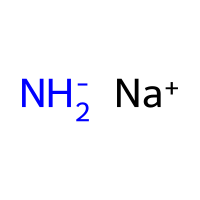
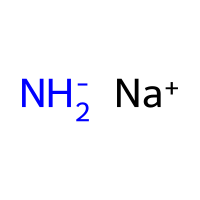
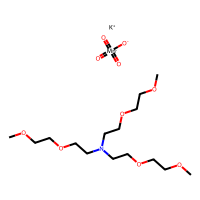
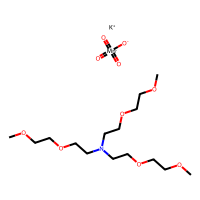
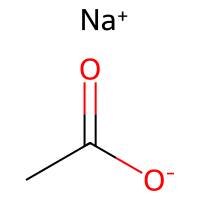
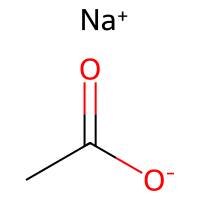
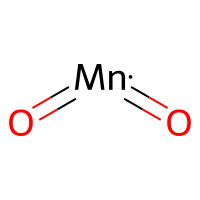
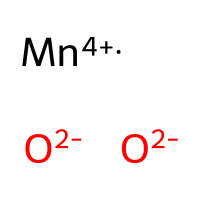
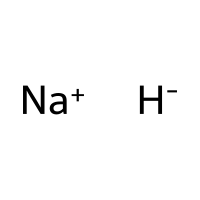
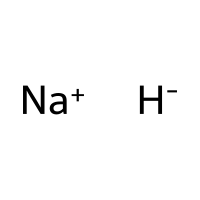
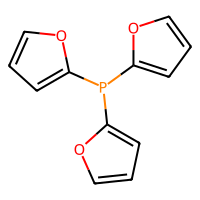
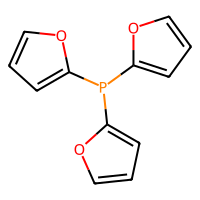
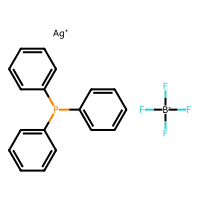
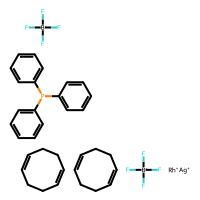
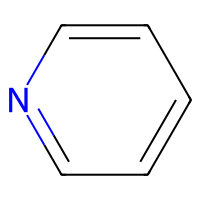
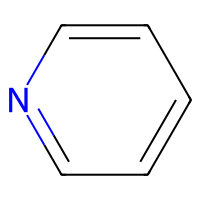
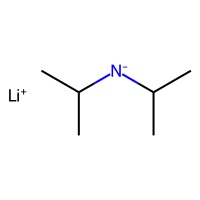
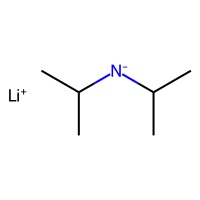
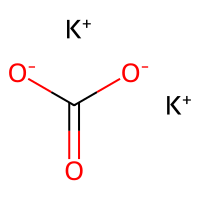
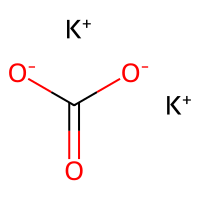
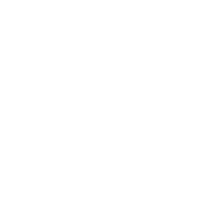
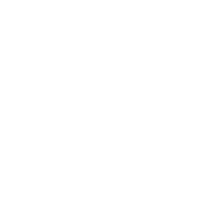
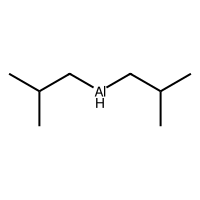
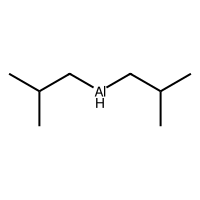
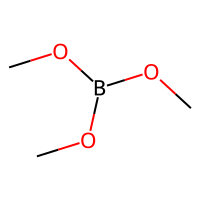
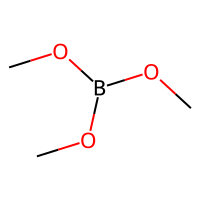
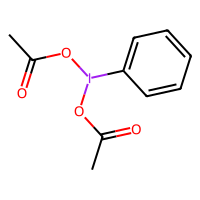
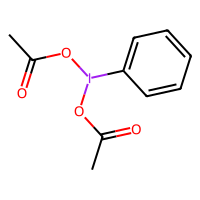
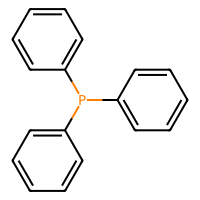
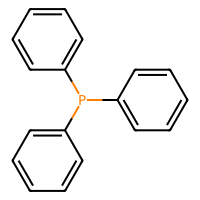
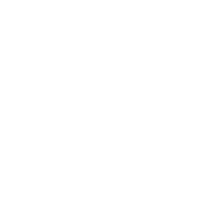
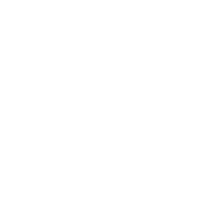
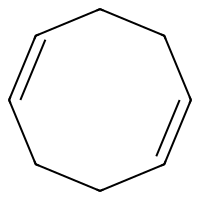
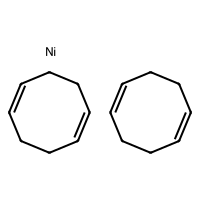
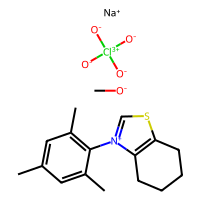
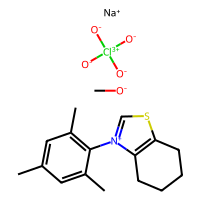
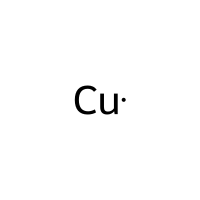
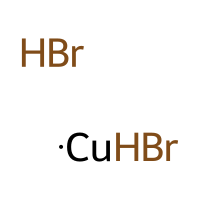
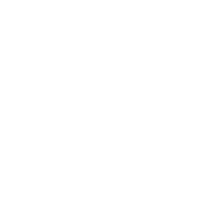
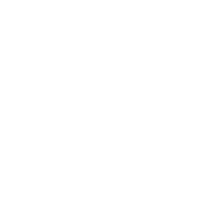
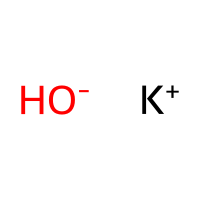
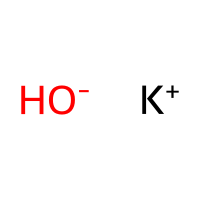
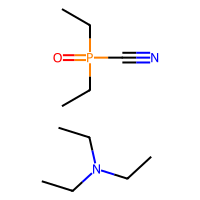
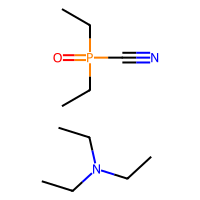
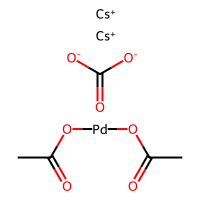
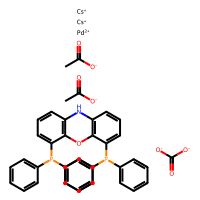
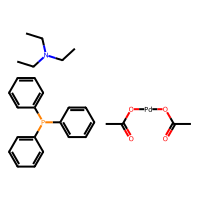
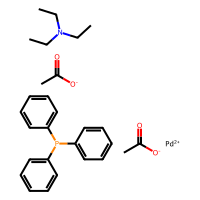
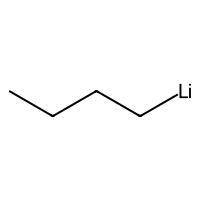
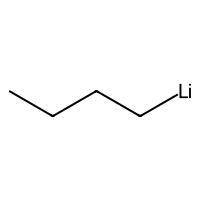
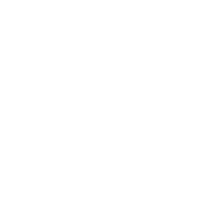
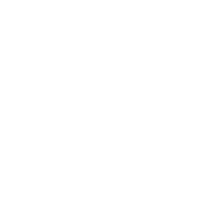
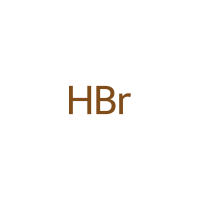
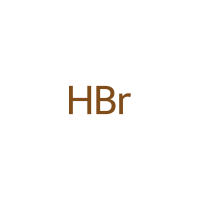
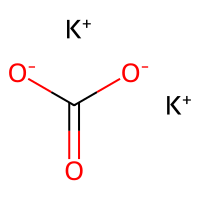
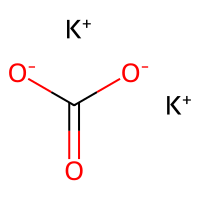
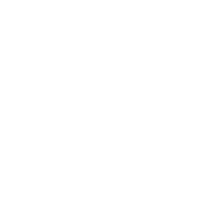
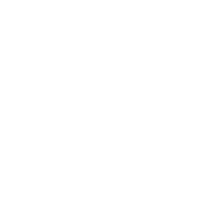
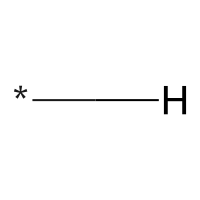
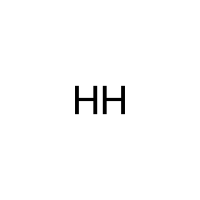
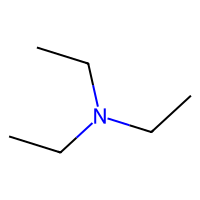
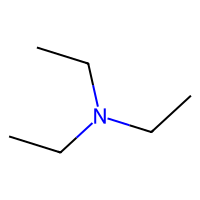
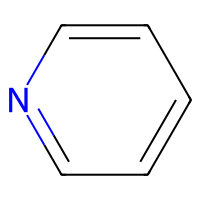
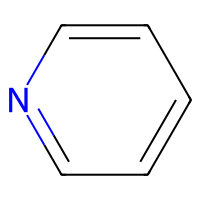
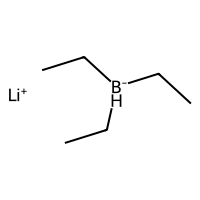
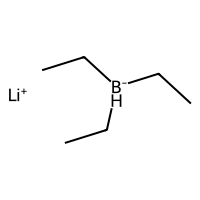
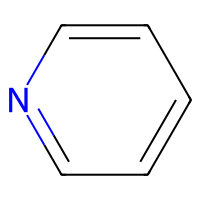
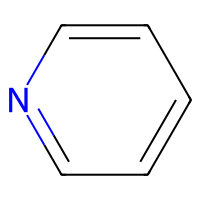
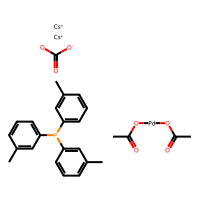
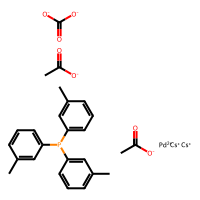
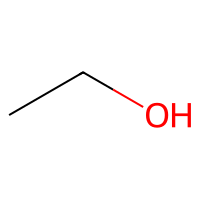
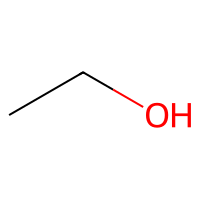
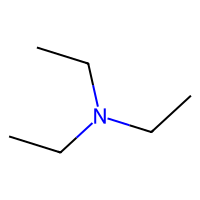
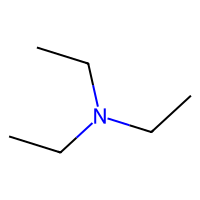
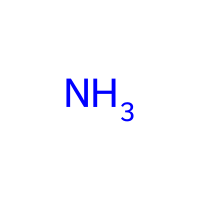
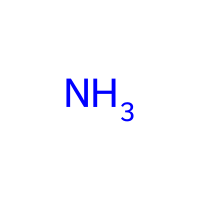
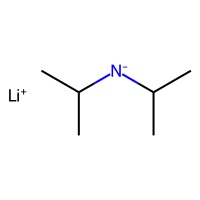
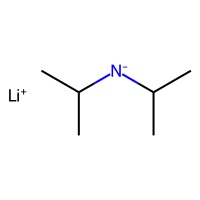
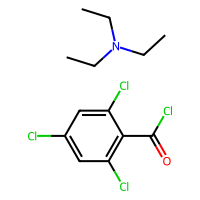
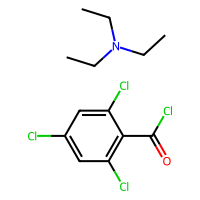
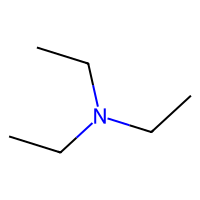
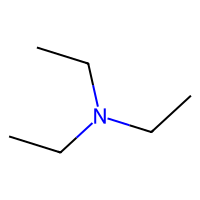
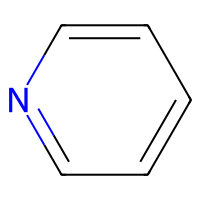
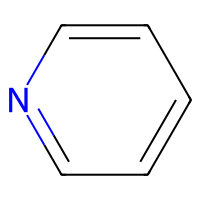
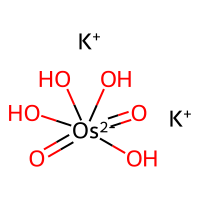
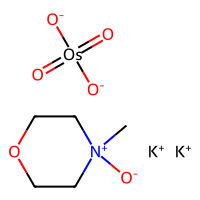
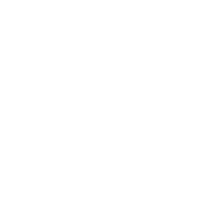
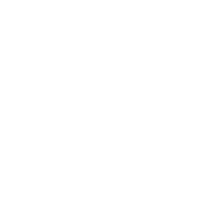
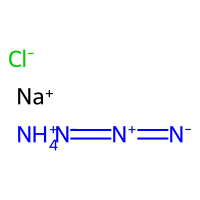
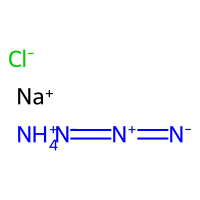
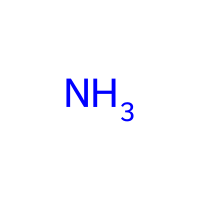
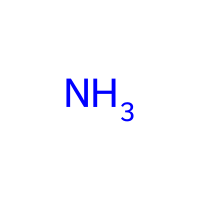
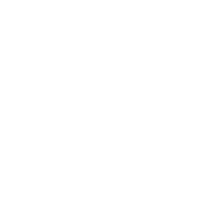
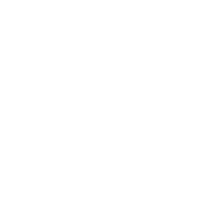
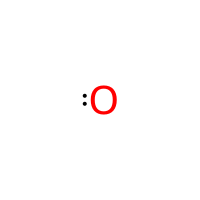
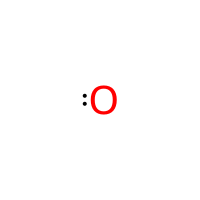
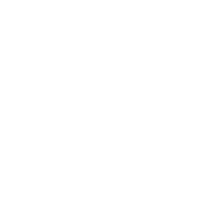
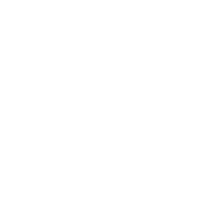
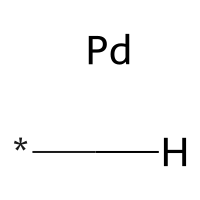
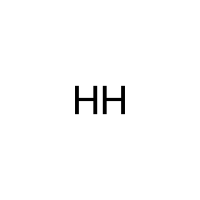
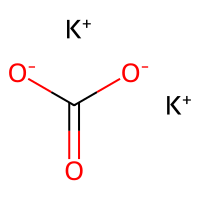
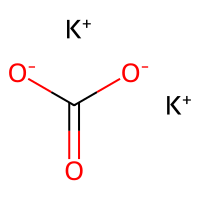
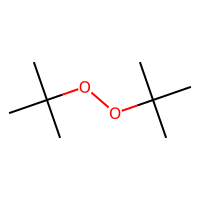
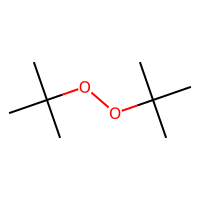
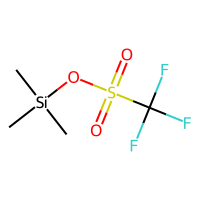
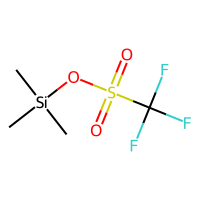
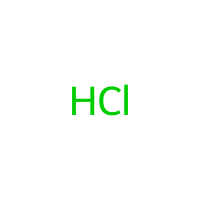
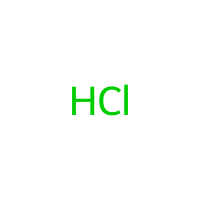
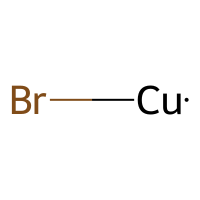
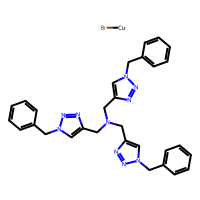
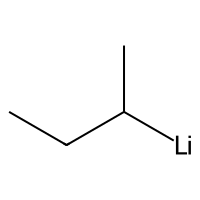
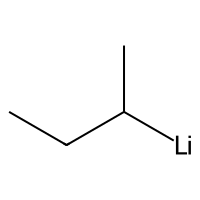
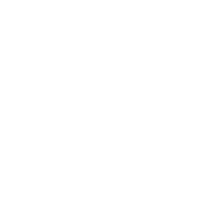
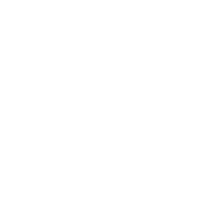
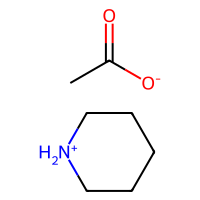
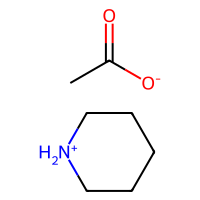
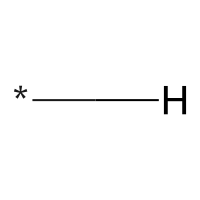
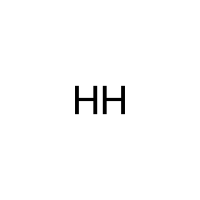
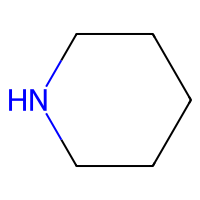
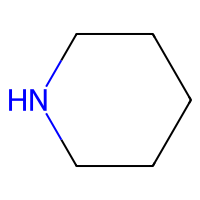
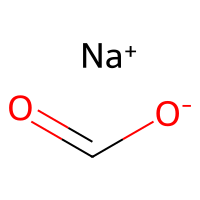
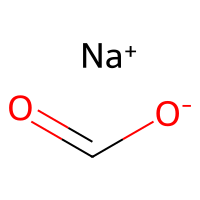
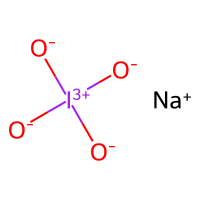
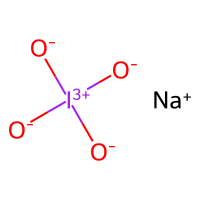
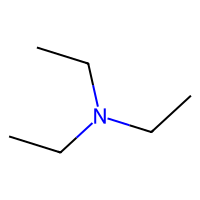
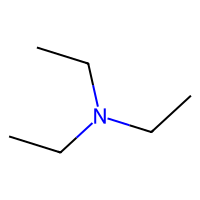
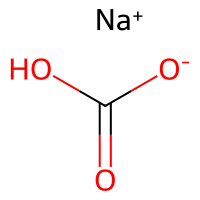
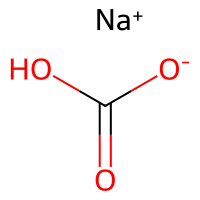
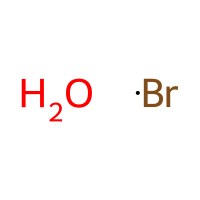
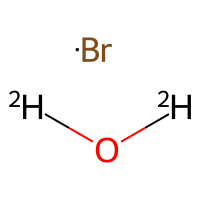
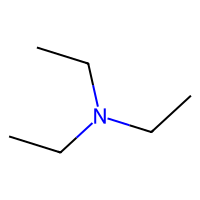
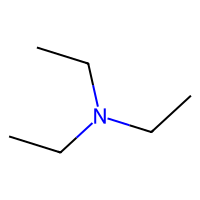
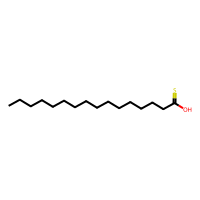
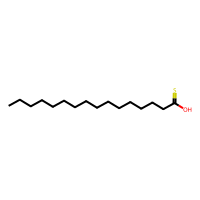
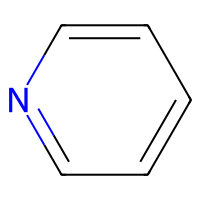
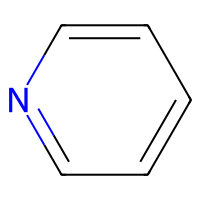
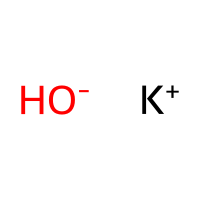
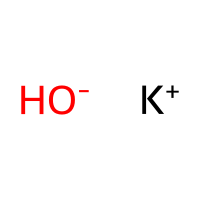
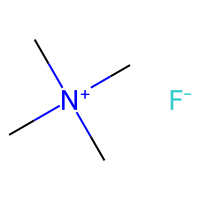
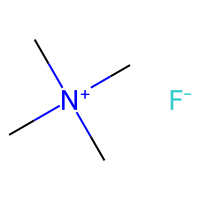
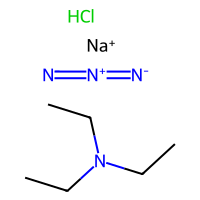
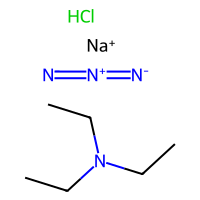
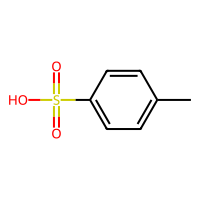
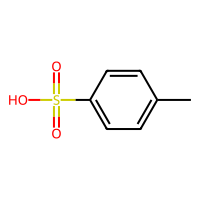
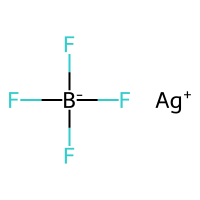
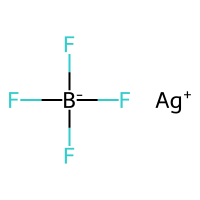
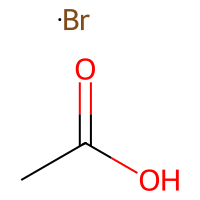
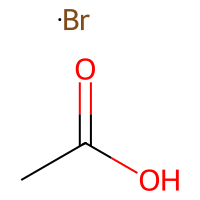
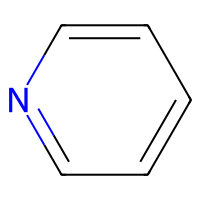
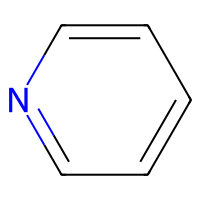
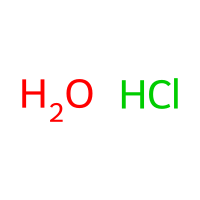
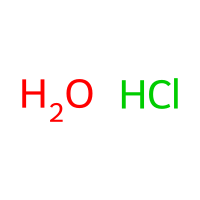
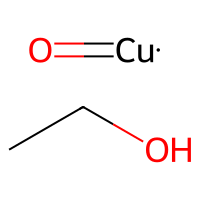
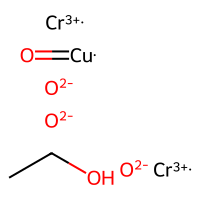
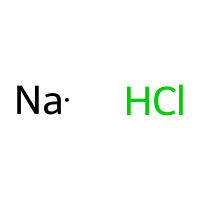
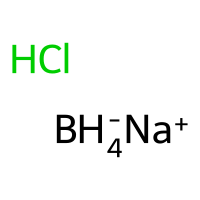
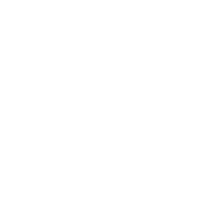
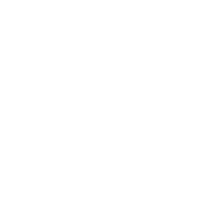
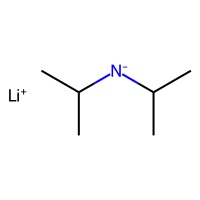
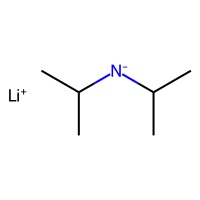
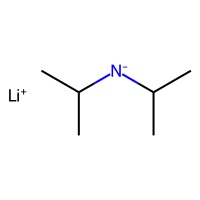
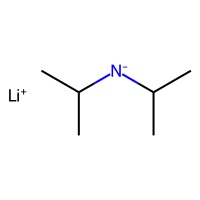
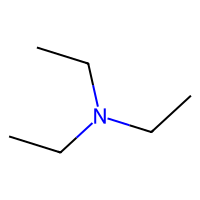
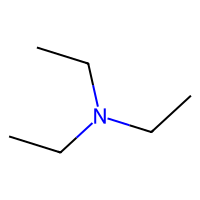
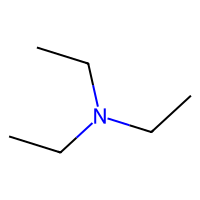
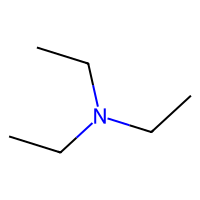
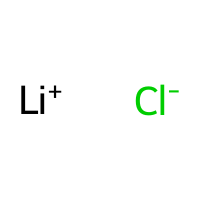
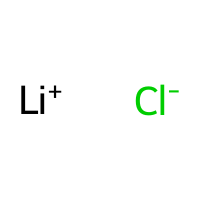
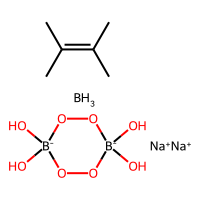
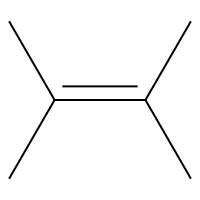
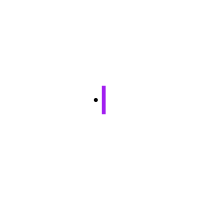
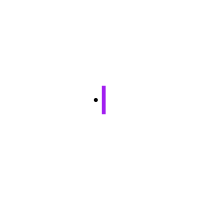
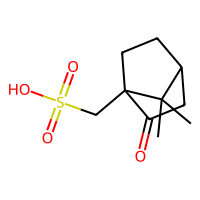
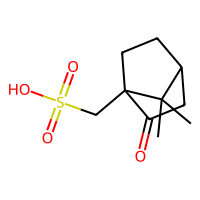
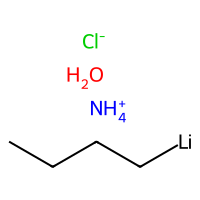
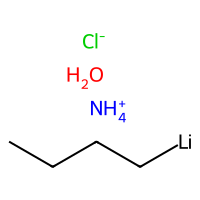
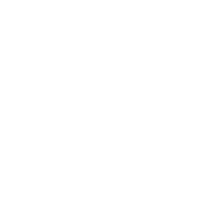
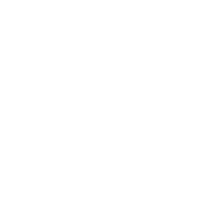
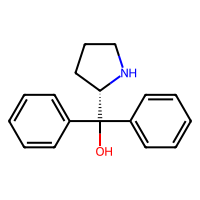
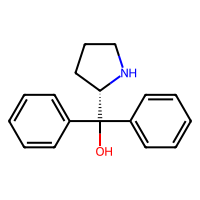
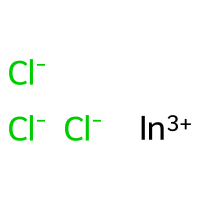
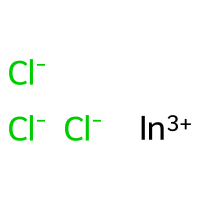
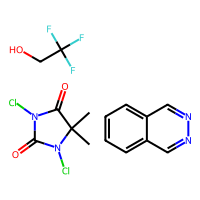
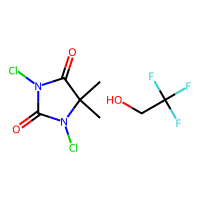
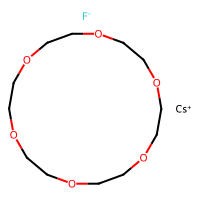
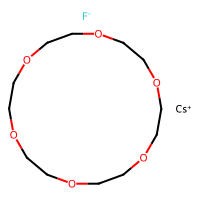
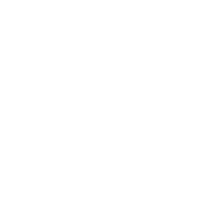
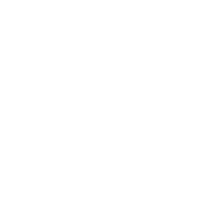
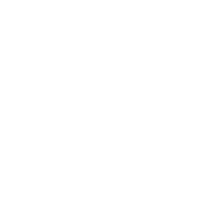
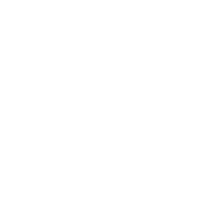
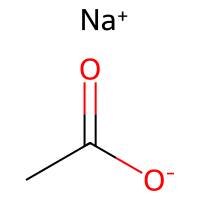
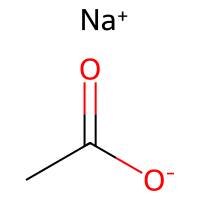
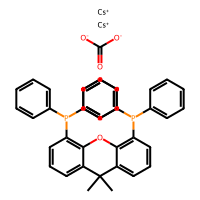
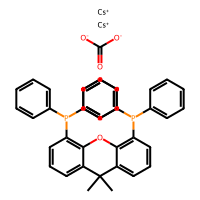
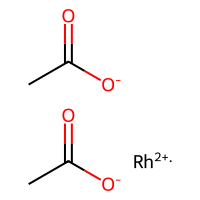
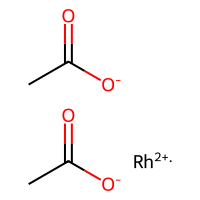
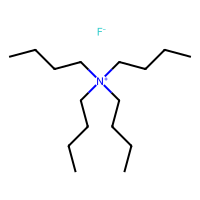
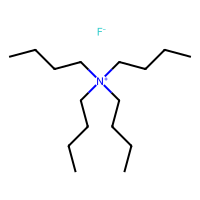
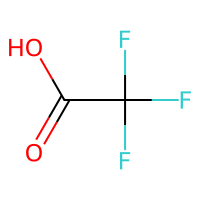
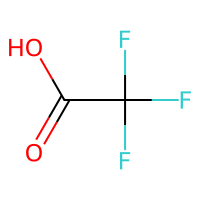
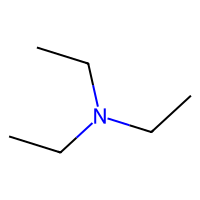
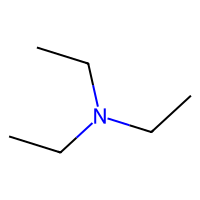
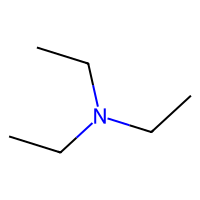
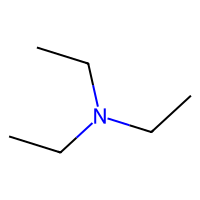
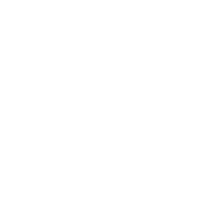
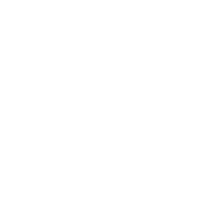
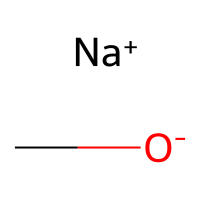
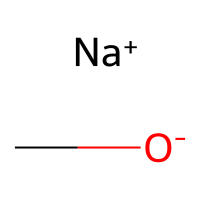
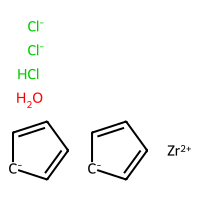
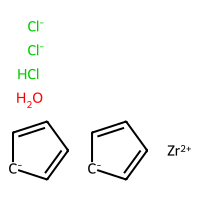
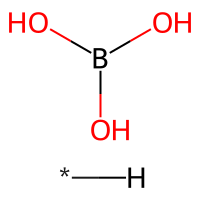
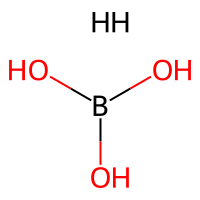
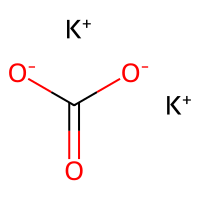
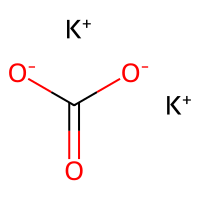
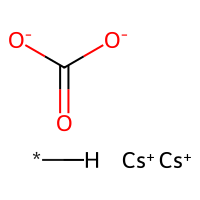
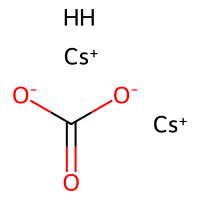
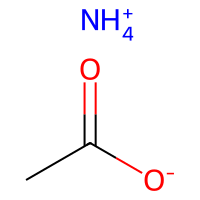
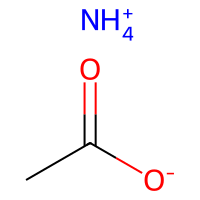
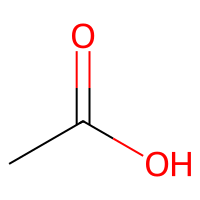
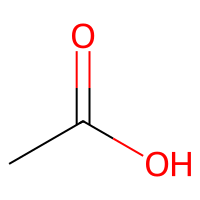
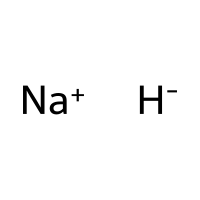
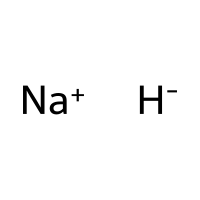
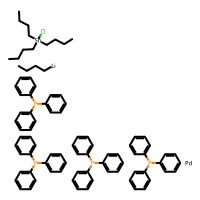
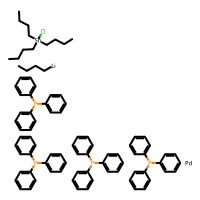
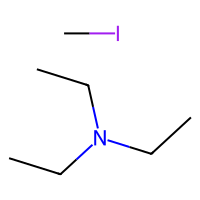
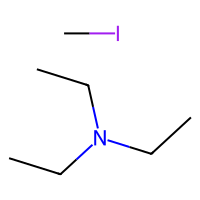
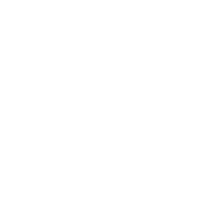
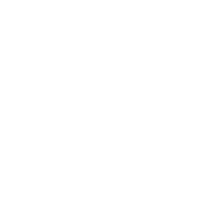
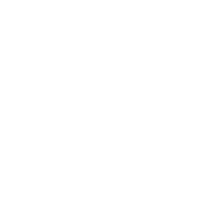
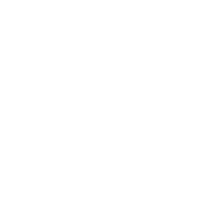
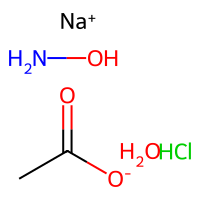
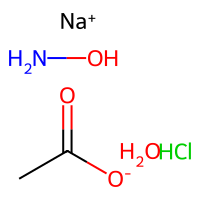
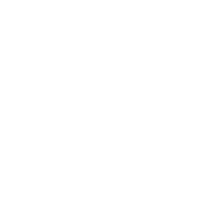
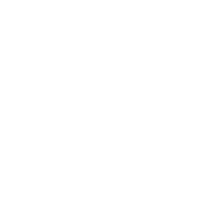
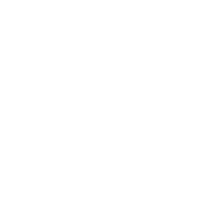
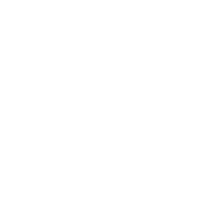
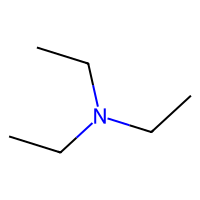
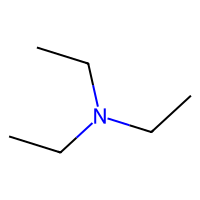

In [68]:
part_1_reagent

In [79]:
row_n = 145
print(part_1_reagent.loc[row_n, "reagent"])
print(part_1_reagent.loc[row_n, "canonical_leadmine"])
print(part_1_reagent.loc[row_n, "canonical_pubchem"])

# print SMILES that are present in canonical_leadmine but not in canonical_pubchem
print(
    'SMILES that are present in part_2_reagent.loc[35, "canonical_leadmine"] but not in part_2_reagent.loc[35, "canonical_leadmine"]: '
)
print(
    set(part_1_reagent.loc[row_n, "canonical_leadmine"].split("."))
    - set(part_2_reagent.loc[row_n, "canonical_pubchem"].split("."))
)
# print SMILES that are present in canonical_pubchem but not in canonical_leadmine
print(
    'SMILES that are present in part_2_reagent.loc[35, "canonical_pubchem"] but not in part_2_reagent.loc[35, "canonical_leadmine"]: '
)
print(
    set(part_1_reagent.loc[row_n, "canonical_pubchem"].split("."))
    - set(part_2_reagent.loc[row_n, "canonical_leadmine"].split("."))
)

slvektsiikdftlfekmseheqvvfcndpatglraiiaihdttlgpalggcrmqpynsveealedalrlskgmtyscaasdvdfgggkaviigdpqkdkspelfrafgqfvdslggrfytgtdmgtnmedfihamketncivgvpeaygssgnpspataygvyrgmkaaakeafgsdslegkvvavqgvgnvayhlcrhlheegaklivtdinkeavaraveefgakavdpndiygvecdifapcalggiindqtipqlkakviagsalnqlkeprhgdmihemgivyapdyvinaggcinvadelygynreramkkieqiydniekvfaiakrdniptyvaadrmaeerietmrkarsqflqnghhilsrrrar


SMILES that are present in part_2_reagent.loc[35, "canonical_leadmine"] but not in part_2_reagent.loc[35, "canonical_leadmine"]: 
{''}
SMILES that are present in part_2_reagent.loc[35, "canonical_pubchem"] but not in part_2_reagent.loc[35, "canonical_leadmine"]: 
{''}


Check second part

,reagent,canonical_leadmine,canonical_pubchem,is_correct,leadmine_image,pubchem_image
0,phosphorus pentachloride,ClP(Cl)(Cl)(Cl)Cl,ClP(Cl)(Cl)(Cl)Cl,True,,
1,acetic acid,CC(=O)O,CC(=O)O,True,,
2,potassium phosphate,O=P([O-])([O-])[O-].[K+].[K+].[K+],O=P([O-])([O-])[O-].[K+].[K+].[K+],True,,
3,hydrogen|acetic acid|ethyl acetate,*[H].CC(=O)O.CCOC(C)=O,CC(=O)O.CCOC(C)=O.[HH],False,,
4,potassium carbonate|morpholine|tetrakis(triphe...,C1CCC2=NCCCN2CC1.C1COCCN1.O=C([O-])[O-].[K+].[...,C1CCC2=NCCCN2CC1.C1COCCN1.O=C([O-])[O-].[K+].[...,True,,
5,hydrogenchloride|acetic acid|mercury|zinc,CC(=O)O.Cl.[Hg].[Zn],CC(=O)O.Cl.[Hg].[Zn],True,,
6,n-bromosuccinmide,,,False,,
7,hydrogen,*[H],[HH],False,,
8,n-butyllithium,[Li]CCCC,[Li]CCCC,True,,
9,n-ethyl morpholine|(benzotriazo-1-yloxy)tris(d...,CCN1CCOCC1.CN(C)[PH+](N(C)C)N(C)C.F[P-](F)(F)(...,CCN1CCOCC1,False,,

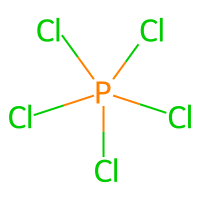
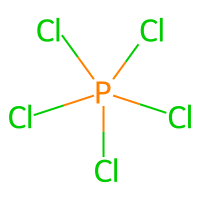
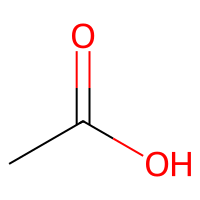
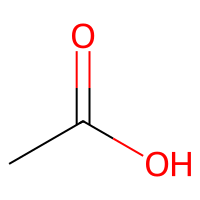
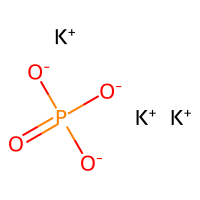
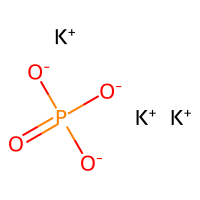
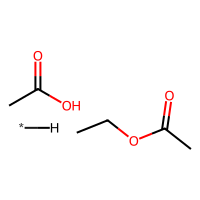
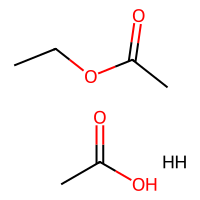
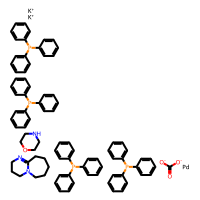
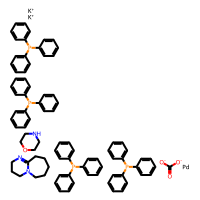
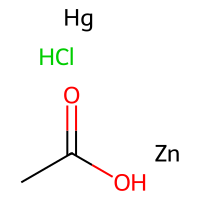
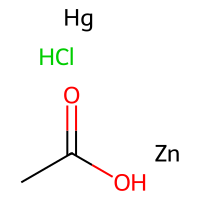
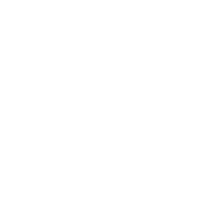
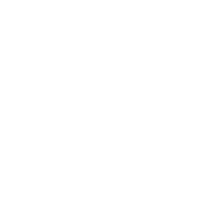
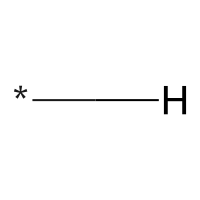
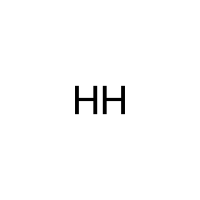
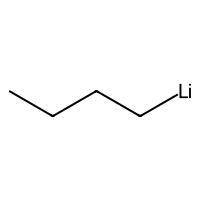
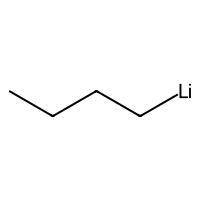
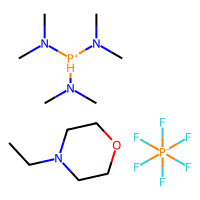
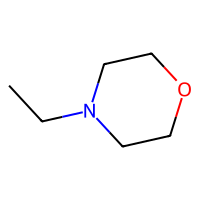
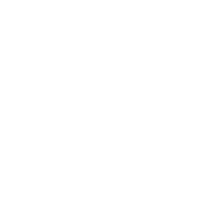
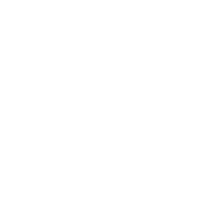
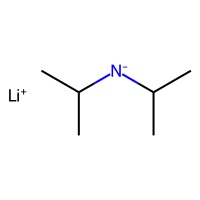
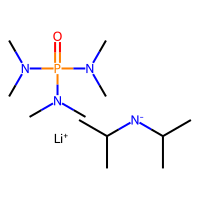
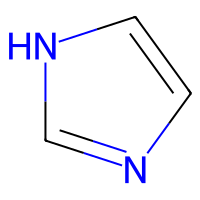
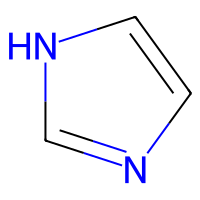
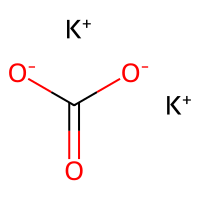
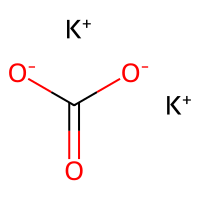
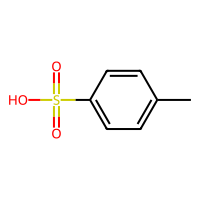
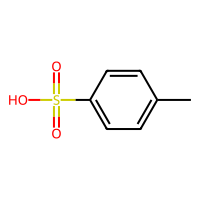
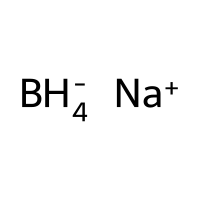
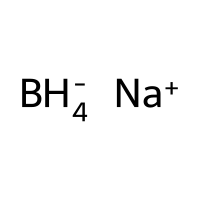
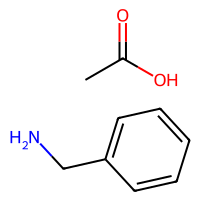
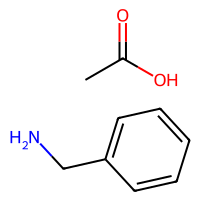
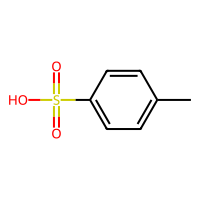
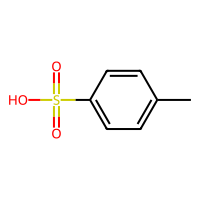
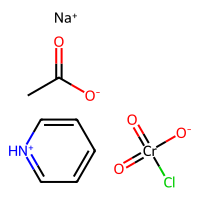
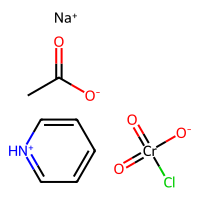
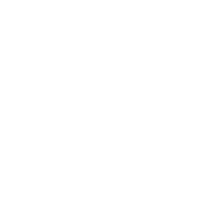
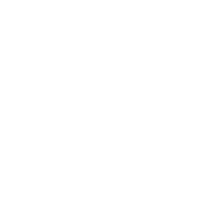
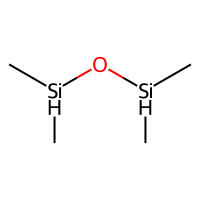
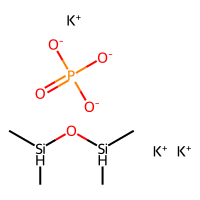
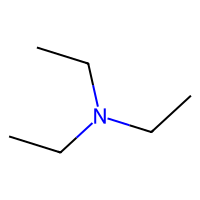
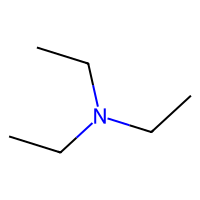
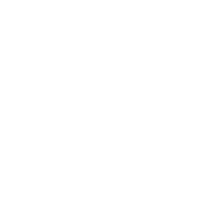
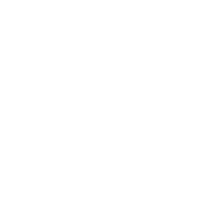
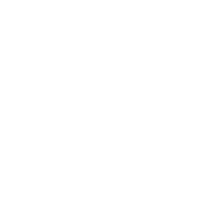
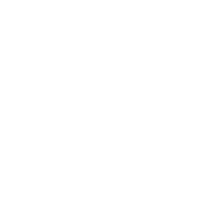
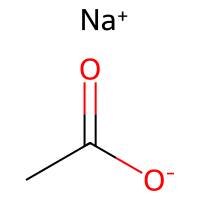
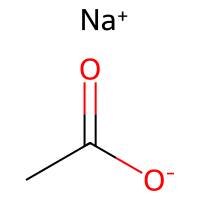
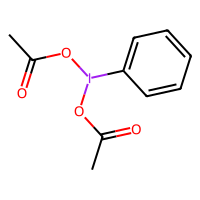
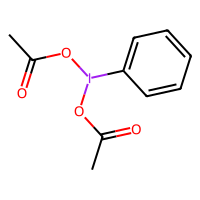
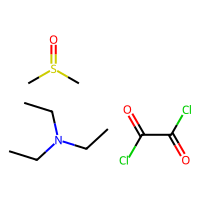
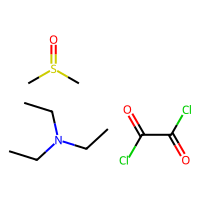
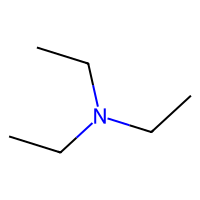
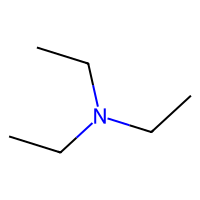
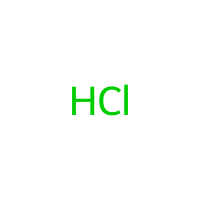
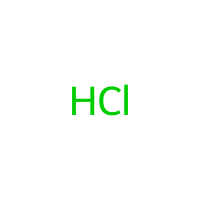
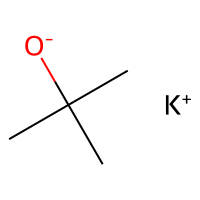
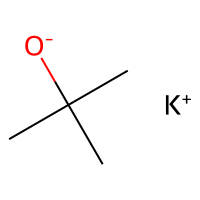
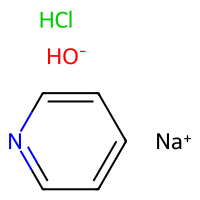
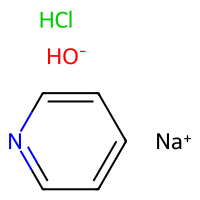
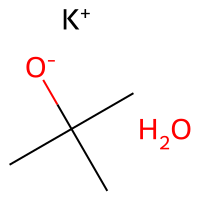
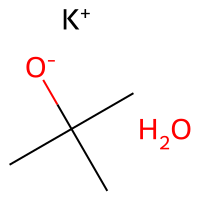
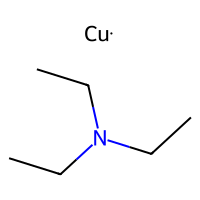
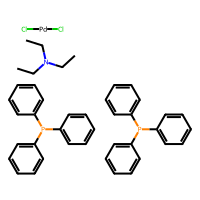
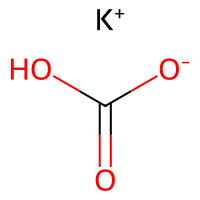
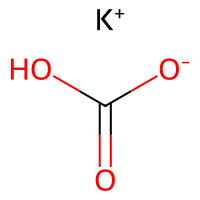
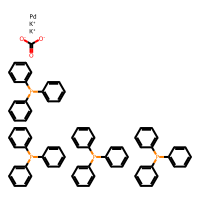
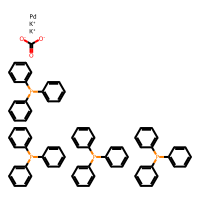
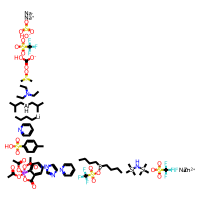
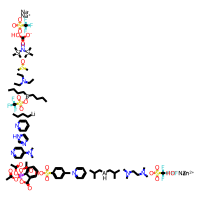
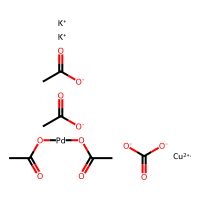
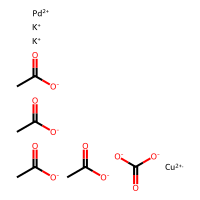
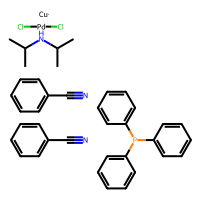
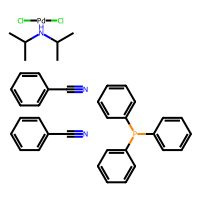
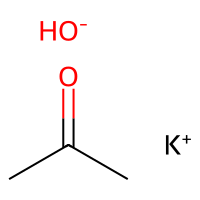
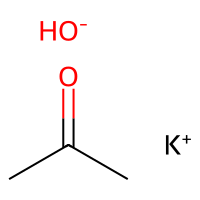
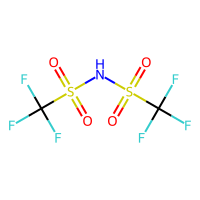
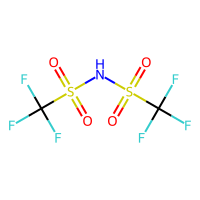
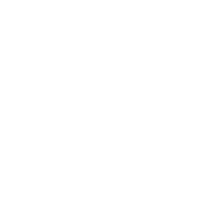
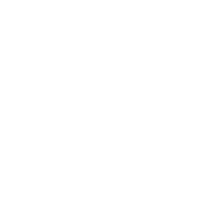
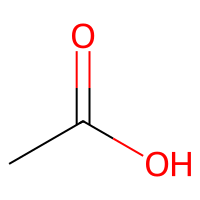
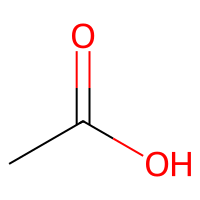
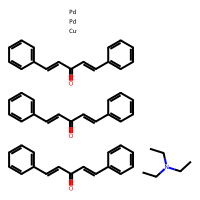
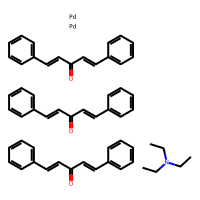
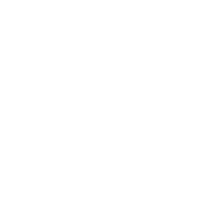
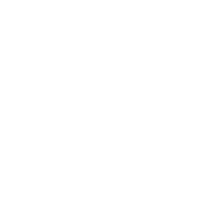
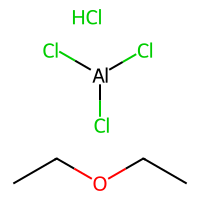
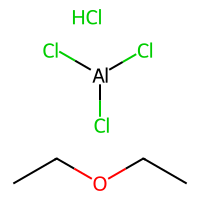
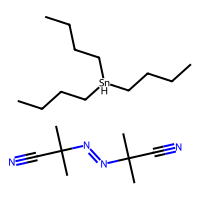
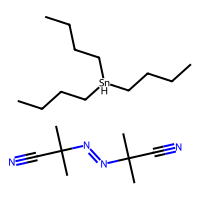
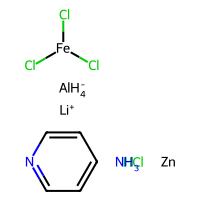
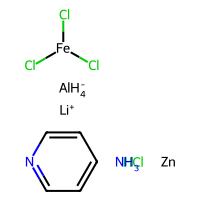
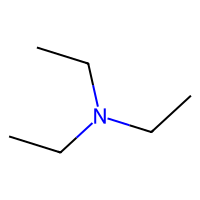
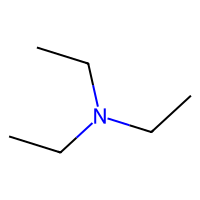
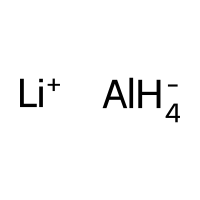
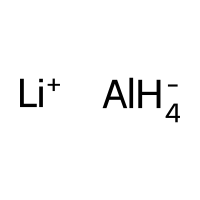
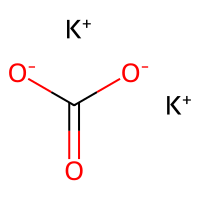
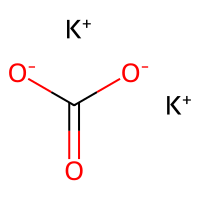
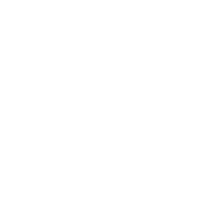
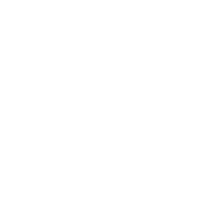
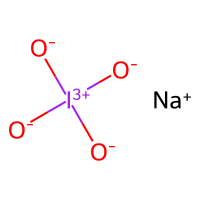
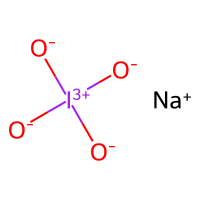
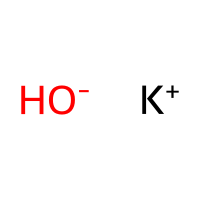
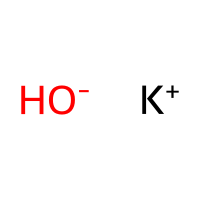
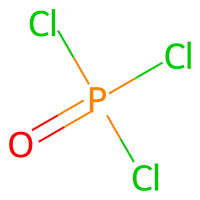
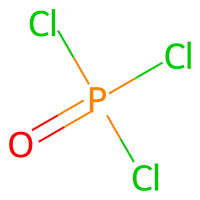
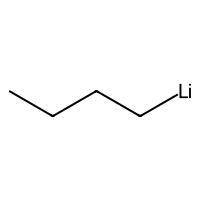
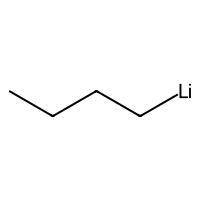
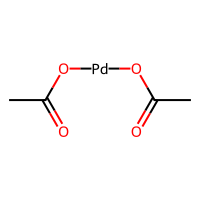
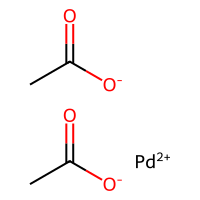
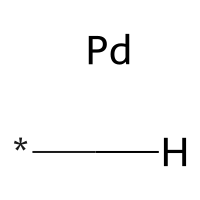
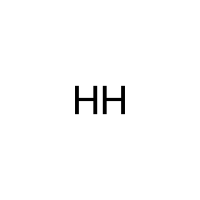
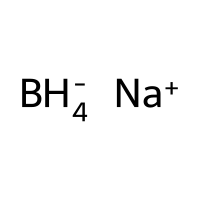
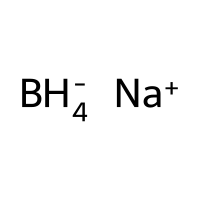
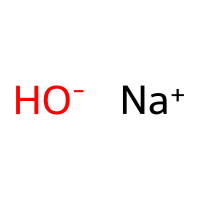
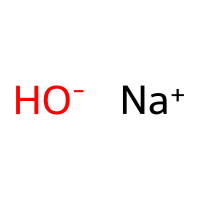
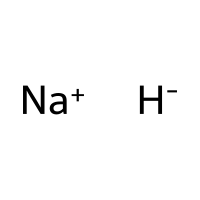
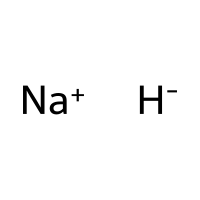
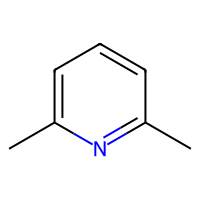
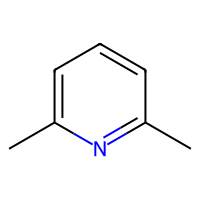
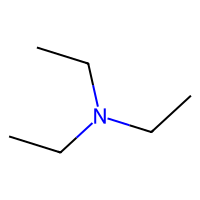
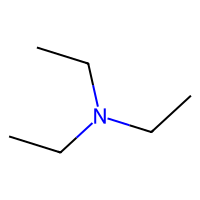
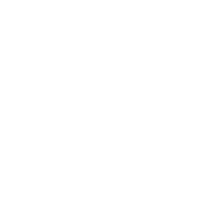
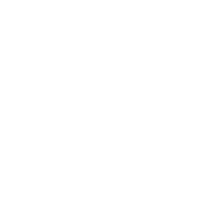
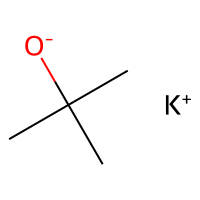
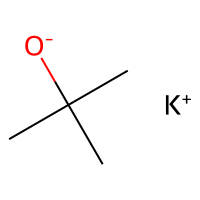
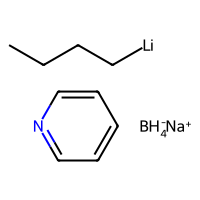
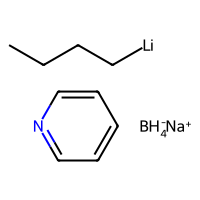
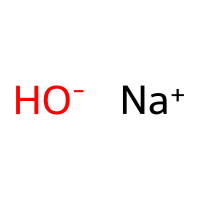
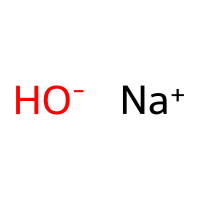
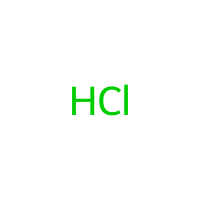
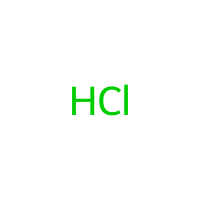
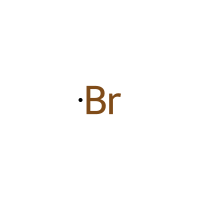
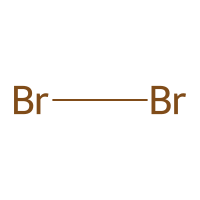
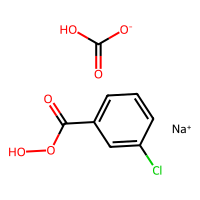
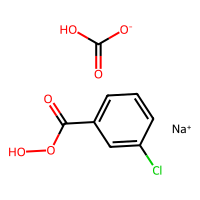
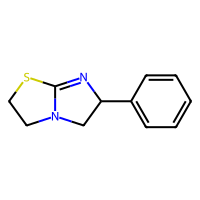
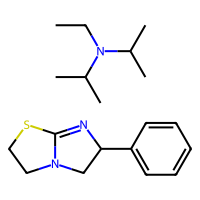
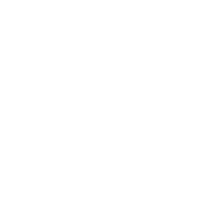
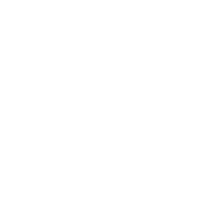
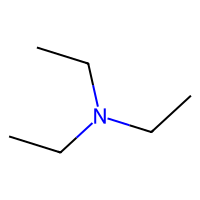
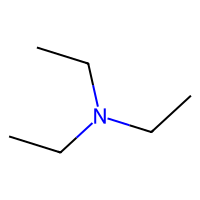
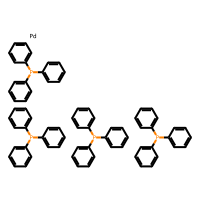
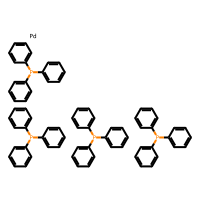
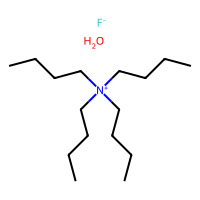
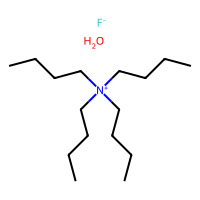
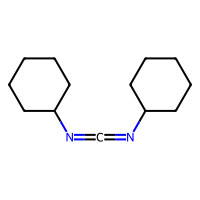
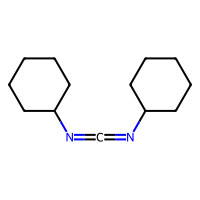
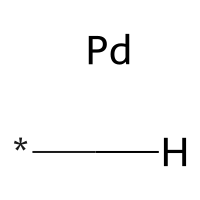
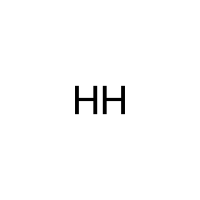
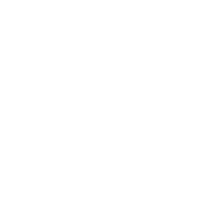
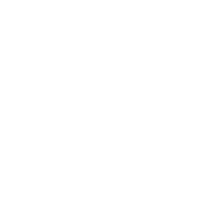
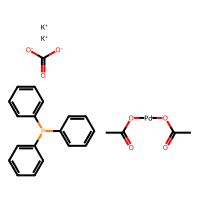
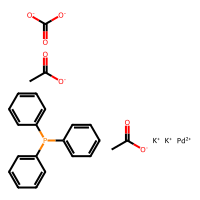
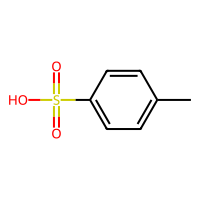
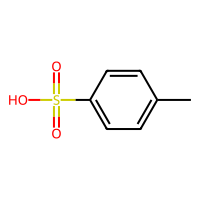
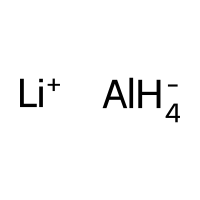
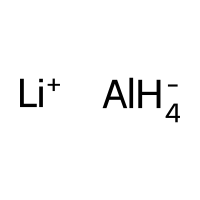
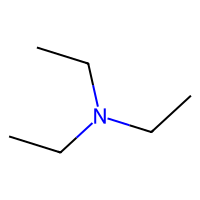
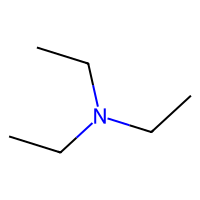
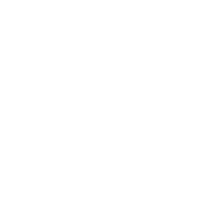
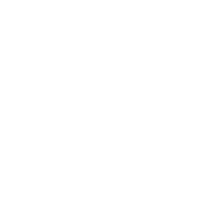
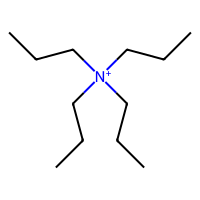
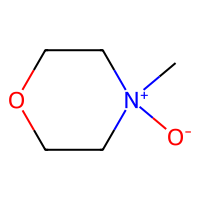
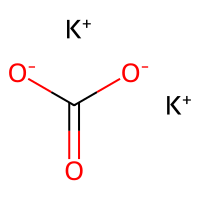
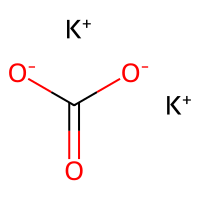
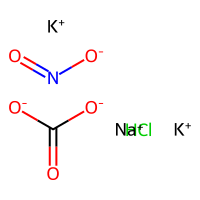
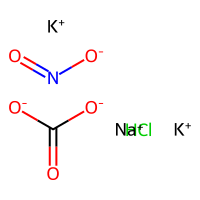
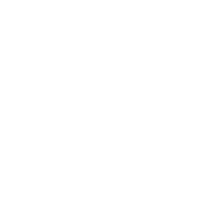
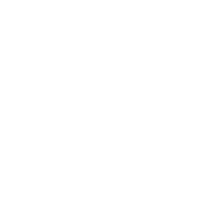
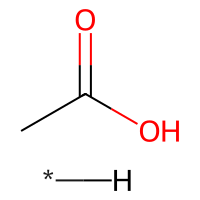
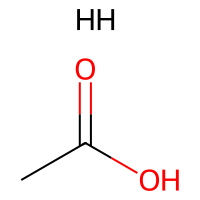
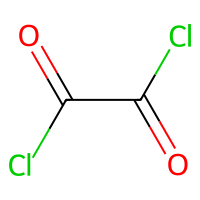
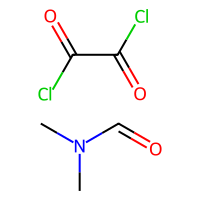
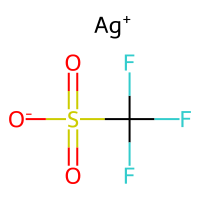
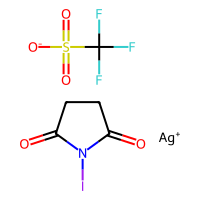
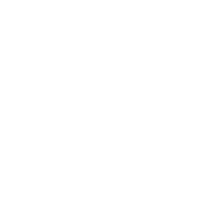
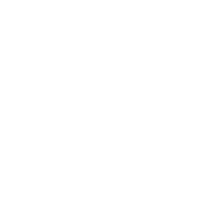
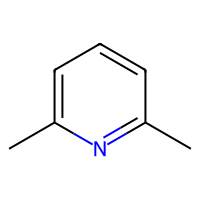
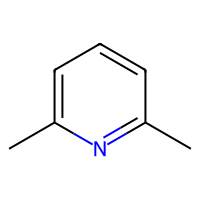
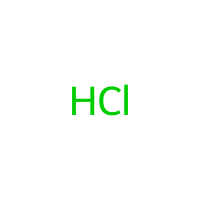
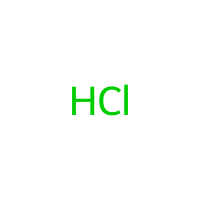
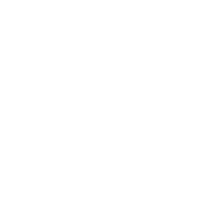
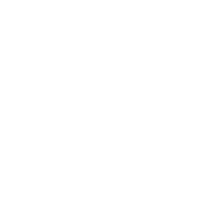
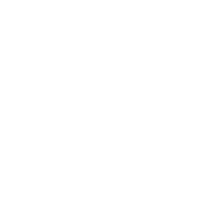
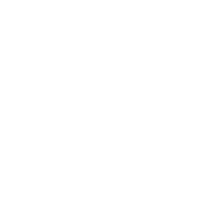
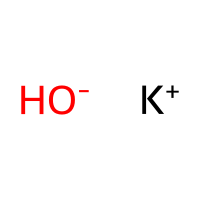
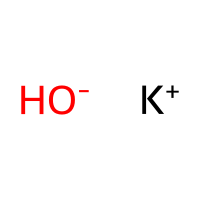
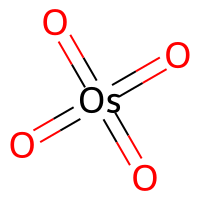
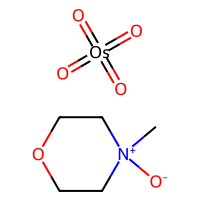
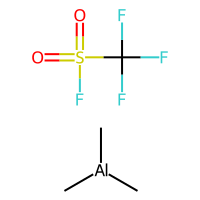
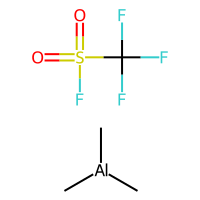
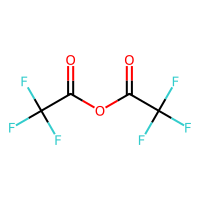
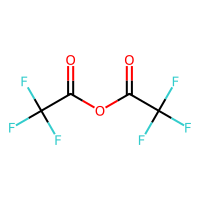
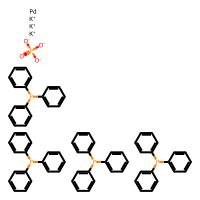
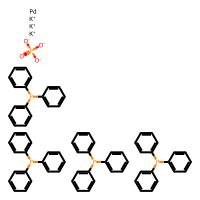
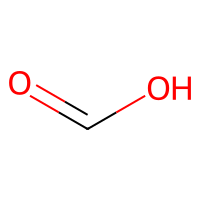
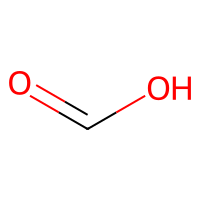
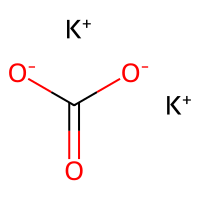
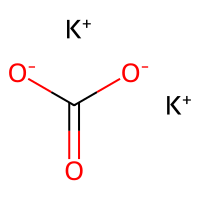
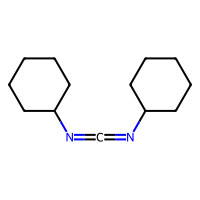
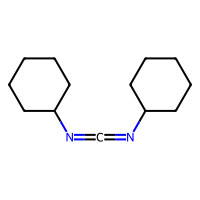
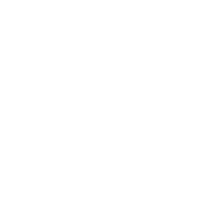
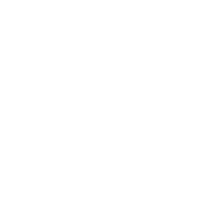
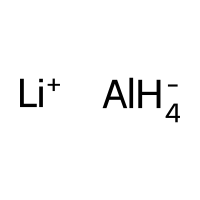
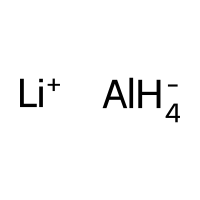
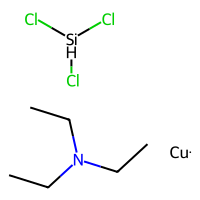
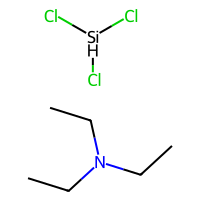
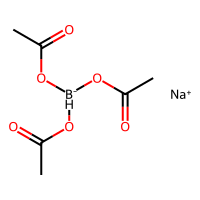
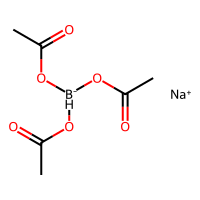
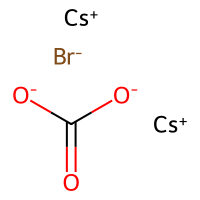
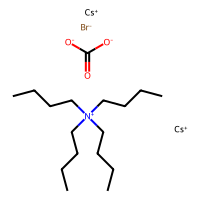
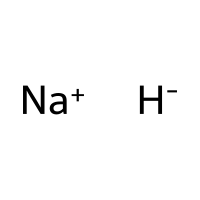
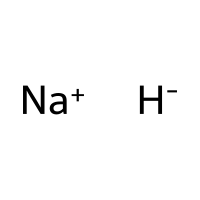
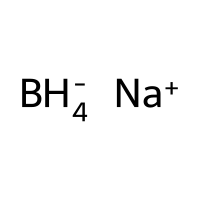
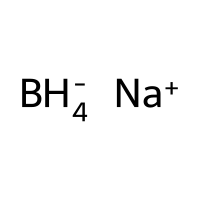
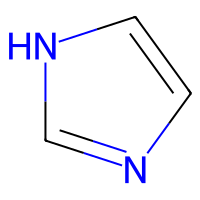
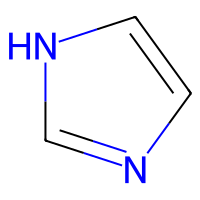
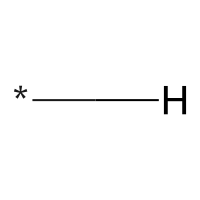
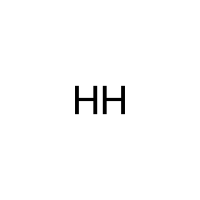
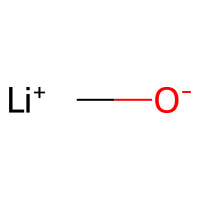
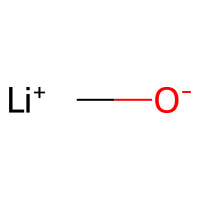
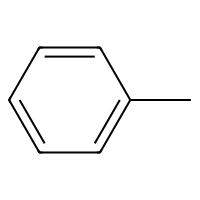
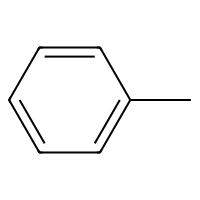
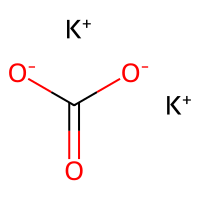
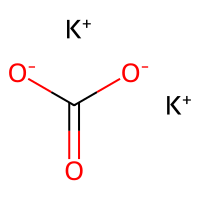
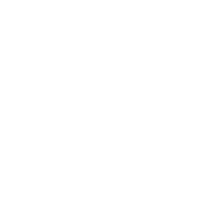
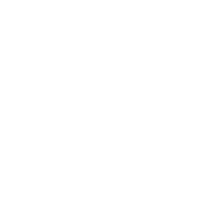
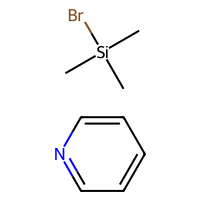
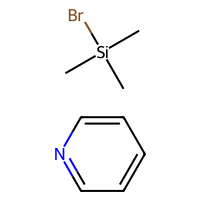
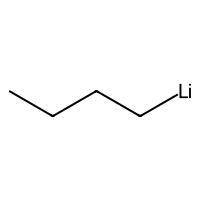
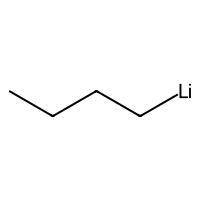
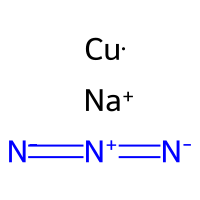
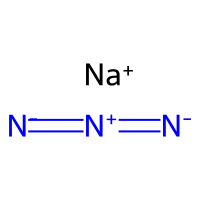
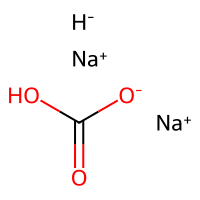
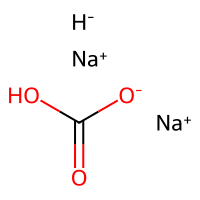
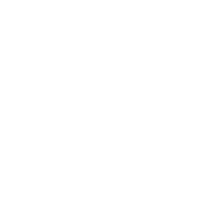
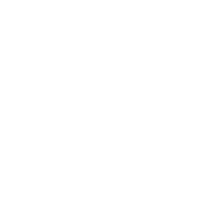
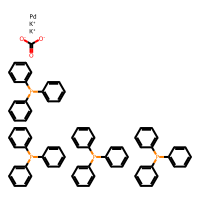
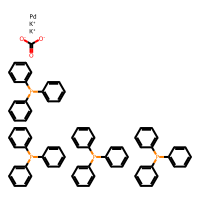
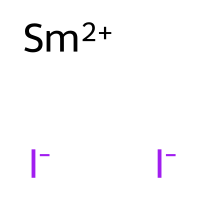
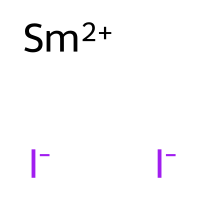
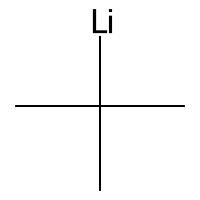
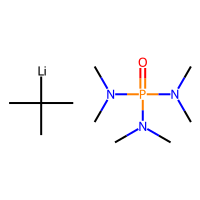
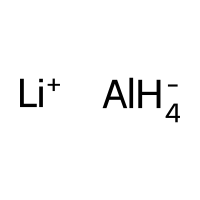
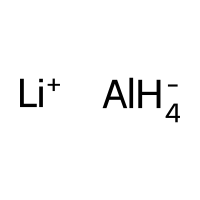
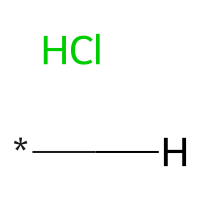
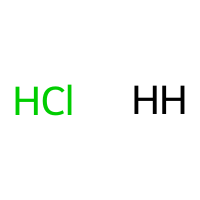
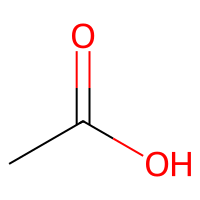
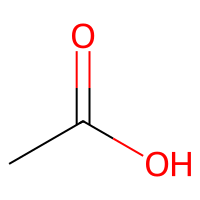
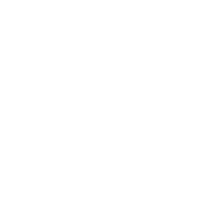
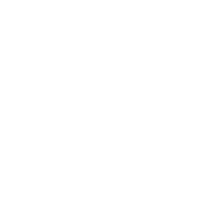
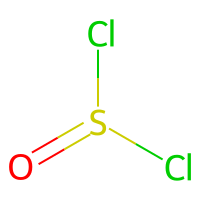
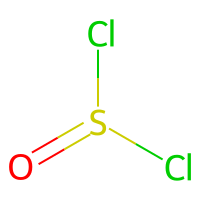
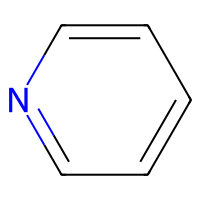
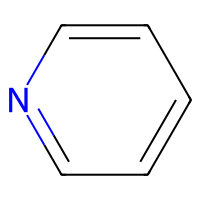
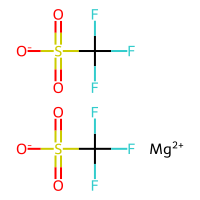
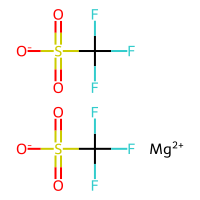
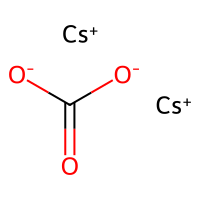
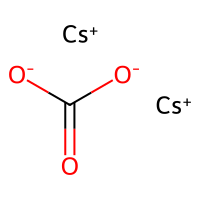
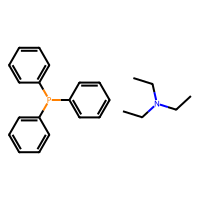
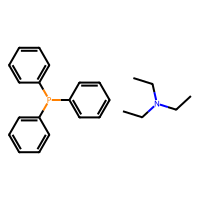
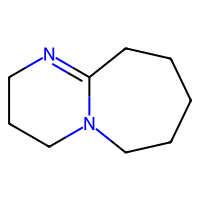
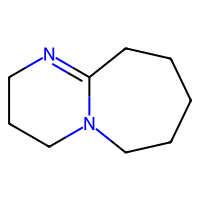
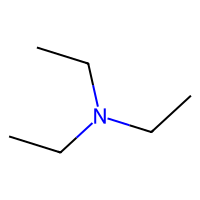
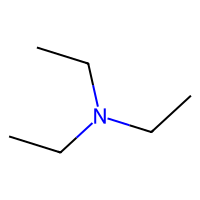
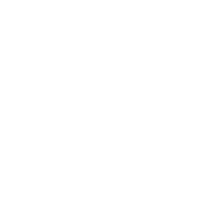
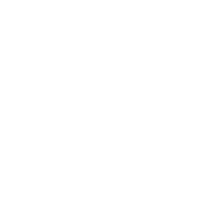
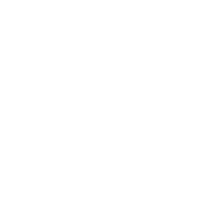
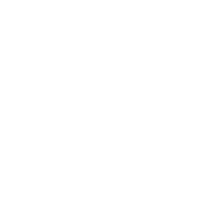
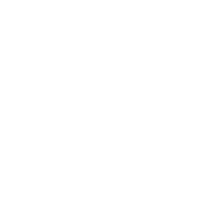
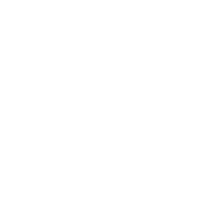
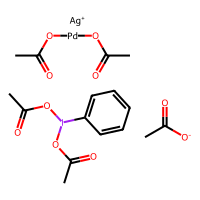
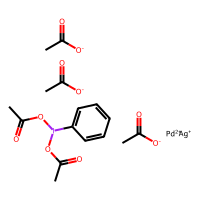
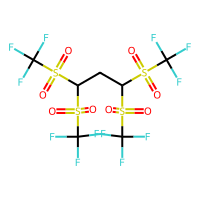
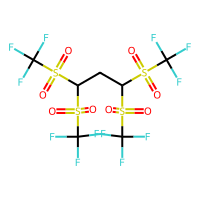
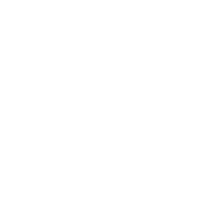
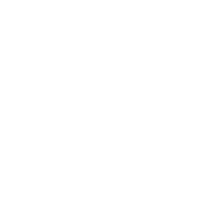
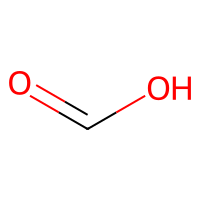
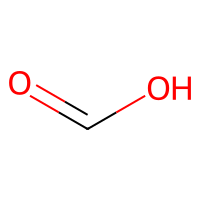
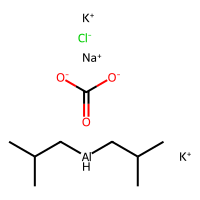
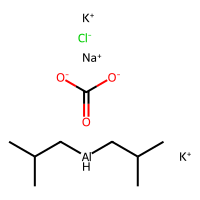
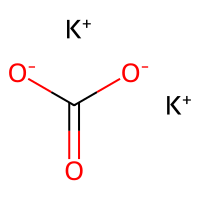
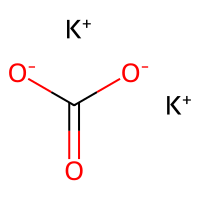
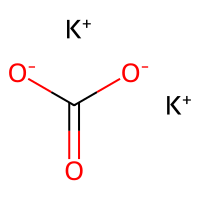
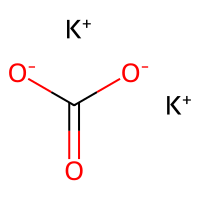
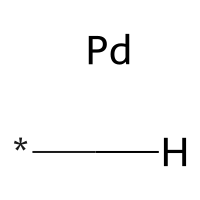
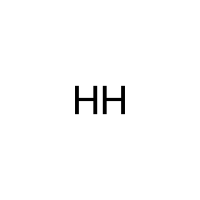
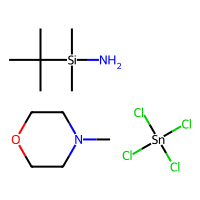
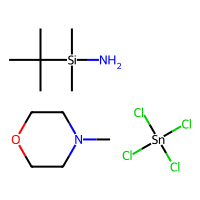
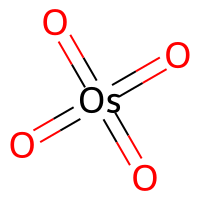
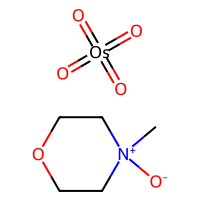
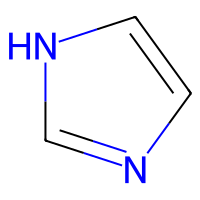
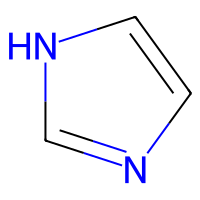
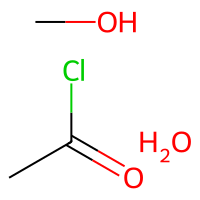
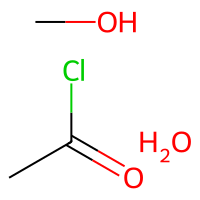
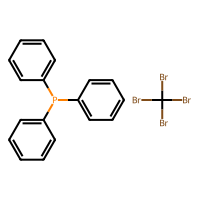
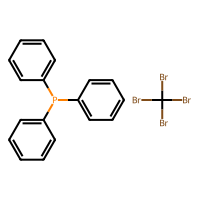

In [83]:
part_2_reagent

In [82]:
# run some statistics
# first create a dataframe where the reagent column does not contain any empty strings
df = part_2_reagent[part_2_reagent["reagent"] != "empty"]

# then print in how many rows:
# canonical_leadmine and canonical_pubchem have the same string
# canonical_leadmine has an empty string and canonical_pubchem has a SMILES string
# canonical_leadmine has a SMILES string and canonical_pubchem has an empty string
# canonical_leadmine and canonical_pubchem have different SMILES strings

print(
    "canonical_leadmine and canonical_pubchem have the same string: ",
    len(
        df[
            (df["canonical_leadmine"] != "")
            & (df["canonical_pubchem"] != "")
            & (df["canonical_leadmine"] == df["canonical_pubchem"])
        ]
    ),
)
print(
    "canonical_leadmine and canonical_pubchem have the same string but it's empty: ",
    len(
        df[
            (df["canonical_leadmine"] == "")
            & (df["canonical_pubchem"] == "")
            & (df["canonical_leadmine"] == df["canonical_pubchem"])
        ]
    ),
)
print(
    "canonical_leadmine has an empty string and canonical_pubchem has a SMILES string: ",
    len(
        df[
            (df["canonical_leadmine"] == "empty")
            & (df["canonical_pubchem"] != "")
        ]
    ),
)
print(
    "canonical_leadmine has a SMILES string and canonical_pubchem has an empty string: ",
    len(
        df[
            (df["canonical_leadmine"] != "empty")
            & (df["canonical_pubchem"] == "")
        ]
    ),
)
print(
    "canonical_leadmine and canonical_pubchem have different SMILES strings: ",
    len(
        df[
            (df["canonical_leadmine"] != "")
            & (df["canonical_pubchem"] != "")
            & (df["canonical_leadmine"] != df["canonical_pubchem"])
        ]
    ),
)

canonical_leadmine and canonical_pubchem have the same string:  96
canonical_leadmine and canonical_pubchem have the same string but it's empty:  8
canonical_leadmine has an empty string and canonical_pubchem has a SMILES string:  0
canonical_leadmine has a SMILES string and canonical_pubchem has an empty string:  8
canonical_leadmine and canonical_pubchem have different SMILES strings:  30


### Conclusion

In general, PubChem seems to be more accurate than Leadmine (out of 300 examples, there are 23 where Leadmine fails but PubChem gives the correct SMILES and only 5 where Leadmine gives the correct SMILES but PubChem not). However, PubChem is not able to translate all the names and there are around 31 examples where both fail, so we will use PubChem as the main translator and a dictionary of names to SMILES to correct the errors (at least the ones we have detected).

Here are some names where both failed

n-bromosuccinmide
3 a molecular sieve
fpifa 
?ni(pcy3)2cl2
copper(l) iodide
p-(tert-bu)3-hbf4
para-thiocresol
nbu4n(+)so4h(-)
[mecnau((1,1?-biphenyl-2-yl)-di-tert-butylphosphine)]+sbf6?
tetrapropylammonium perruthennate
dbu
1-ethyl-(3-(3-dimethylamino)propyl)-carbodiimide hydrochloride|
n-ethyl-n,n-diisopropylamine
potassium 2-methyl-2-butoxide	
cuso4?5h2o	
[imesnih]otf		
4-(n,n-dimethlyamino)pyridine	
2-hydroxy-n,n,n-trimethyl-ethanaminium
grubb's 2nd generation catalyst
(ra)-3,5-xylyl-binap
[pdcl2(phcn)2]
sodium borodeuteride
n,n'-dimethyl-n,n'-propyleneurea
1.54h2o*cl2ni|
icy*hbf4
1,4-bis(9-o-dihydroquinidinyl)phthalazine
c82h94irn7o4
tetraphosphorus decasulfide
c34h58nip2
iodine
bromine							

Here some names where Leadmine is correct but PubChem not

sulfur trioxide pyridine complex
palladium 10 on activated carbon
2,2,2-trifluroethylamine hydrochloride
borane-thf
sodium perborate tetrahydrate